In [1]:
import pandas as pd
from geopy.geocoders import Nominatim
#Importación del módulo csv que necesitaremos para leer y escribir en nuestros csv
import csv
#Importación del módulo shutil que usaremos para crear una copia de nuestro csv original
import shutil
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pyrematch as re
from shapely.geometry import shape
import numpy as np
import networkx as nx
from time import time 
from pyproj import CRS
from collections import OrderedDict
import operator
from functools import reduce


# Crear grafo de Santiago

### Creamos el grafo de Santiago

In [2]:
place_name = "Provincia de Santiago, Región Metropolitana de Santiago, Chile"
graph = ox.graph_from_place(place_name, network_type = "drive", simplify = False)

In [3]:
ox.speed.add_edge_speeds(graph, hwy_speeds=None, fallback=None, precision=1)

**Obtenemos los df de nodos y arcos**

In [4]:
nodes, edges = ox.graph_to_gdfs(graph)

**Agregamos columna de tiempo de viaje**

In [5]:
edges['Tiempos de Viaje'] = 0
edges['Tiempos de Viaje'] = edges.apply(lambda x: ((edges['length']/1000)/edges['speed_kph'])) #horas

# Congestión

### Funciones que servirán para dar efecto congestión
Creamos función que disminuirá la velocidad  del los arcos, dependiendo de la hora y minuto del día

In [6]:
def interpolacion_lineal(x,x1,x2,y1,y2):
    y = ((y2-y1)/(x2-x1))*(x-x1)+y1
    return(y)

In [7]:
def interpolacion_cuadratica(x, fx):
    b0 = fx[0]
    b1 = (fx[1]-fx[0])/(x[1]-x[0])
    b2 = (((fx[2]-fx[1])/(x[2]-x[1]))-((fx[1]-fx[0])/(x[1]-x[0])))/(x[2]-x[0])
    f2 = b0+b1*(x[3]-x[0])+b2*(x[3]-x[0])*(x[3]-x[1])
    return(f2)

### Función tiempo final aplicada a la red

In [8]:
def actualizar_tiempo(x, y, mes, hora, minutos): #x es velocidad e y es distancia
    y = y/1000
    dic_dism = {1:[(20.19/43.15),((20.19+14.09)/43.15),(18.51/43.15)],2:[(21.03/43.15),((21.03+14.09)/43.15),(19.14/43.15)], 3:[(16.89/43.15),((16.89+14.09)/43.15),(17.39/43.15)], 4:[(16.93/43.15),((16.93+14.09)/43.15),(17.38/43.15)], 5:[(17.19/43.15),((17.19+14.09)/43.15),(17.17/43.15)], 6:[(17.34/43.15),((17.34+14.09)/43.15),(17.08/43.15)], 7:[(18.46/43.15),((18.46+14.09)/43.15),(17.21/43.15)], 8:[(16.76/43.15),((16.76+14.09)/43.15),(16.94/43.15)], 9:[(17.15/43.15),((17.15+14.09)/43.15),(17.24/43.15)], 10:[(16.78/43.15),((16.78+14.09)/43.15),(17.02/43.15)], 11:[(16.57/43.15),((16.57+14.09)/43.15),(17.03/43.15)], 12:[(18.11/43.15),((18.11+14.09)/43.15),(17.13/43.15)]}
    #Punta mañana [0], Valle [1], Punta Tarde [2]
    if ((7 <= hora <= 8) and (0 <= minutos <= 59)):
        x = interpolacion_cuadratica([5, 8, 10.5, (hora+(minutos/60))], [x, x*dic_dism[mes][0], interpolacion_lineal(10.5,8,13.5,x*dic_dism[mes][0],x*dic_dism[mes][1])])
    elif ((9 <= hora <= 17) and (0 <= minutos <= 59)):
        x = interpolacion_cuadratica([10.5, 13.5, 16.25,(hora +(minutos/60))],[interpolacion_lineal(10.5,8,13.5,x*dic_dism[mes][0],x*dic_dism[mes][1]),x*dic_dism[mes][1], interpolacion_lineal(16.25,13.5,19,x*dic_dism[mes][1],x*dic_dism[mes][2])])
    elif ((18 <= hora <= 19) and (0 <= minutos <= 59)):
        x = interpolacion_cuadratica([16.25, 19, 22, (hora+(minutos/60))],[interpolacion_lineal(16.25,13.5,19,x*dic_dism[mes][1],x*dic_dism[mes][2]),x*dic_dism[mes][2],x])
    return (y/x) #horas

**Ahora probamos la función para los diferentes horarios**

00:03 hrs.

In [9]:
#nodes, edges = ox.graph_to_gdfs(graph)

In [10]:
#actualizar_tiempo(x, y, mes, hora, minutos)
#edges['Tiempo de Viaje'][10:20]

8:33 hrs.

In [11]:
#nodes, edges = ox.graph_to_gdfs(graph)

In [12]:
#actualizar_tiempo(x, y, mes, hora, minutos)
#edges['Tiempo de Viaje'][10:20]

10:32 hrs.

In [13]:
#nodes, edges = ox.graph_to_gdfs(graph)

In [14]:
#actualizar_tiempo(x, y, mes, hora, minutos)
#edges['Tiempo de Viaje'][10:20]

13:00 hrs.

In [15]:
#nodes, edges = ox.graph_to_gdfs(graph)

In [16]:
#actualizar_tiempo(x, y, mes, hora, minutos)
#edges['Tiempo de Viaje'][10:20]

13:30 hrs.

In [17]:
#nodes, edges = ox.graph_to_gdfs(graph)

In [18]:
#actualizar_tiempo(x, y, mes, hora, minutos)
#edges['Tiempo de Viaje'][10:20]

18:20 hrs.

In [19]:
#nodes, edges = ox.graph_to_gdfs(graph)

In [20]:
#actualizar_tiempo(x, y, mes, hora, minutos)
#edges['Tiempo de Viaje'][10:20]

# Subgrafo y Simplificaciones
Debido al tamaño del grafo de Santiago, es necesario crear una función que obtenga un subgrafo a partir de un nodo y una área determinada.

In [119]:
def subgrafo(graph, src, direccion_x, direccion_y, m, n):
    subgrafo = nx.ego_graph(graph, src, radius = (ox.distance.great_circle_vec(direccion_x[m], direccion_y[m], direccion_x[n], direccion_y[n], earth_radius = 6371009)/100)+210, center=True, undirected=False, distance=None)
    return subgrafo

Además, se realizan simplificaciones para reducir el número de iteraciones, y se eliminan los nodso tipo "isla"

In [ ]:
graph_s = ox.simplification.simplify_graph(graph, strict=True, remove_rings=True)
remove = [node for node,degree in dict(graph_s.degree()).items() if degree < 2]
graph_s.remove_nodes_from(remove)

# Función Dijsktra dependiente del tiempo
Función dijkstra con heap binario, dependiente del tiempo y que considera la congestión

In [220]:
from heapq import *
def dijkstra_tiempo(graph, src, dest, mes, hora, minutos, visited = set(), times={}, predecessors={}):
    
    """ calculates a shortest path tree routed in src
    """    
    if src == dest:
        #print('LLEGÓ AL DESTINO------------------')
        # We build the shortest path and display it
        path=[]
        pred=dest
        while pred != None:
            path.append(pred)
            pred=predecessors.get(pred,None)
        # reverses the array, to display the path nicely
        readable=path[0]

        return(path, times[dest])
        
    else : 
        # if it is the initial  run, initializes the cost
        if not visited: 
            times[src] = 0
            
        #print('SRC', src)
        #print('graph', graph)
        for neighbor in graph[src] :
            print('neighbor', neighbor)
            print('visited', visited)
            if neighbor not in visited:
                x = graph[src][neighbor][0]['speed_kph']
                y = graph[src][neighbor][0]['length']
                act_time = actualizar_tiempo(x, y, mes, hora, minutos) #horas
                new_time = times[src] + act_time # tiempo acumulado en horas
                if new_time < times.get(neighbor,float('inf')):
                    times[neighbor] = new_time
                    predecessors[neighbor] = src
                    print(predecessors)

        visited.add(src)
        unvisited=[]
        
        for k in graph:
            if k not in visited:
                heappush(unvisited, (times.get(k, float('inf')), k))   

        nodo_actual = heappop(unvisited)[1] 
        return dijkstra_tiempo(graph, nodo_actual, dest, mes, hora, minutos, visited, times, predecessors)  

# Heurística Vecino más Cercano

In [ ]:
# esto tiene que ir antes de hacer recursión
# actualizar la hora y minutos

def ver_tiempo(hora, minutos):
	if minutos >= 60:
		hora += 1
		minutos = minutos - 60

	return hora, minutos

def vecino_cercano(graph, nodes, src, dest, mes, hora, minutos, new_time = 0, visited=set(), historico={}, betados=set(), predecessors={}):
    visited.add(src) 
    """ calculates a shortest path tree routed in src
    """    
    if src == dest:
        #print('LLEGÓ AL DESTINO------------------')
        # We build the shortest path and display it
        path=[]
        pred=dest
        while pred != None:
            path.append(pred)
            pred=predecessors.get(pred,None)
        # reverses the array, to display the path nicely
        readable = path[0]

        return(path, new_time)
        
    else : 
            
        neighbor_list = []
        neighbor_times = []
        neighbor_times_prob = []
        
        for neighbor in graph[src] :
            #vecinos_v = list(graph[neighbor].keys())
            #print('vecinos_v', vecinos_v)
            #for v in vecinos_v:
            #    if v in visited:
            #        vecinos_v.remove(v)
            #        print('vecinos_v modificado, se le borraron vecinos', vecinos_v)
            if neighbor not in visited and neighbor not in betados and nx.has_path(graph, neighbor,dest):
                neighbor_list.append(neighbor)
                x = graph[src][neighbor][0]['speed_kph']
                if type(x) == list:
                    x = sum(x)
                y = graph[src][neighbor][0]['length']
                if type(y) == list:
                    y = sum(y)
                
                act_time = actualizar_tiempo(x, y, mes, hora, minutos)
                neighbor_times.append(act_time)
        
            prob = {}
            for n in range(len(neighbor_times)):
                # agregar a prob
                radio_dest = ox.distance.great_circle_vec(nodes[nodes['osmid'] == neighbor_list[n]]['y'].values[0], 
                                                          nodes[nodes['osmid'] == neighbor_list[n]]['x'].values[0], 
                                                          nodes[nodes['osmid'] == dest]['y'].values[0], 
                                                          nodes[nodes['osmid'] == dest]['x'].values[0], earth_radius = 6371009)
                prob[neighbor_list[n]] = radio_dest
            
              
        print('vecinos', neighbor_list) 
        print('tiempos', neighbor_times) 
        #SE OBTIENE OTRO MÍNIMO, YA QUE EL VECINO MÍNIMO YA FUE VISITADO PERO EL RESTO NO
        siguiente = src
        vv_visitados = True
        
        if len(neighbor_list) > 0:
            prob_values = list(prob.values())
            print('prob_values', prob_values)
            min_value = min(prob_values)
            max_value = max(prob_values)
             
                                                                
            # Aqui estamos actualizando la lista multiplicada por prob, dde revisaremos cercanía al dest
            for n in prob.values():
                if n == min_value: # el más cerca del destino
                    neighbor_times_prob.append(prob_values[prob_values.index(n)] * 0.1)
                elif n == max_value: # el más cerca del destino
                    neighbor_times_prob.append(prob_values[prob_values.index(n)] * 0.5)
                else:
                    neighbor_times_prob.append(prob_values[prob_values.index(n)] * 0.4)
                    
        while len(neighbor_list) > 0 and vv_visitados: 
            print('Entró al bucle con la neighbor_list', neighbor_list)
            indice_min = neighbor_times_prob.index(min(neighbor_times_prob))
            siguiente = neighbor_list[indice_min] # elige siguiente
            print('siguiente sería', siguiente)
            if siguiente in visited:
                print(siguiente, 'ya fue visitado')
                # Se borra de las posibilidades
                neighbor_times_prob.remove(neighbor_times_prob[neighbor_list.index(siguiente)])
                neighbor_times.remove(neighbor_times[neighbor_list.index(siguiente)])
                neighbor_list.remove(siguiente)
                print('neighbor_times y neighbor_list sin', siguiente, 'quedan como')
                print('neighbor_times_prob', neighbor_times_prob)
                print(neighbor_list)
            else:
                print(siguiente, 'no ha sido visitado, se debería salir del bucle')
                vv_visitados = False
                
            #Revisar la lisa de vecinos nueva: Sí aún tiene vecinos repetir lo anterior, sino se devuelve
        print('Si estaba en un bucle, salió')    
        #SE DEVUELVE SI --> No tiene vecinos    
        if len(neighbor_list) == 0:
            #predecessors buscar el elemento que tiene el value  de siguiente y borrarlo (se agrega al set betados),
            #antes borrarlo guardar su key como siguiente
            #dehacer último paso
            betados.add(siguiente)
            print('Se beto a', siguiente)
            siguiente = [predecessors.pop(key) for key in [siguiente]][0]
            print('ruta, dado que se borró un paso', predecessors)
            old_time = historico[siguiente]['tiempo_arco']
            mes = historico[siguiente]['mes']
            hora = historico[siguiente]['hora']
            minutos= historico[siguiente]['minutos']
            new_time = new_time - old_time
        else:
            
            print(src, 'Tiene vecinos decentes y siguiente es', siguiente)
            new_time = new_time + neighbor_times[indice_min]
            predecessors[siguiente] = src
            print('ruta', predecessors)
            historico[src] = {'dest':siguiente, 'mes':mes, 'hora': hora, 'minutos':minutos, 'tiempo_arco': neighbor_times[indice_min]}
            visited.add(siguiente)
            print('visitados', visited)
            minutos = minutos + neighbor_times[indice_min]*60
            print('hora', hora, 'minutos', minutos) # sumar el tiempo del nodo elegido
            hora, minutos = ver_tiempo(hora, minutos)
            print('hora', hora, 'minutos', minutos) # actualizamos
            
        return vecino_cercano(graph, nodes, siguiente, dest, mes, hora, minutos, new_time, visited, historico, betados, predecessors)

# Coordenadas y Nodos Clientes
A partir de los nodos aproximados a los nodos clientes, se obtienen los **ID** de dichos nodos

In [203]:
nodos = pd.read_csv("coord_cercanos.csv")

In [201]:
list_id = []
for row in nodos.iterrows():
    list_id.append(row[1][3])
    
list_id

[1882519127,
 265690338,
 4441341769,
 504500120,
 376264329,
 280840543,
 1260237000,
 6104473133,
 605104441,
 1475696760,
 1882519126,
 4431666677]

Aqui se obtienen las **coordenadas** de dichos nodos:

In [204]:
ClientesAprox = pd.read_csv("coord_cercanos.csv")
direccion_x =[]
direccion_y =[]
for row in ClientesAprox.iterrows():
    direccion_x.append(row[1][1])
    direccion_y.append(row[1][2])

# Probando heurística

En primer lugar, se genera un subgrafo sociado al nodo de inicio:

In [230]:
grafi = subgrafo(graph_s, 265690338, direccion_x, direccion_y, 1, 0)
# ox.plot_graph(grafi)

In [218]:
nodes_s, edges_s = ox.graph_to_gdfs(grafi)

In [231]:
a = vecino_cercano(grafi, nodes_s,  265690338, 1882519127, 6, 9, 0, 0, set(), {}, set(), {})

vecinos [265690337, 376263958]
tiempos [0.011080247131168426, 0.0029900106944462765]
prob_values [15145.598361135768, 15210.146445874796]
Entró al bucle con la neighbor_list [265690337, 376263958]
siguiente sería 265690337
265690337 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
265690338 Tiene vecinos decentes y siguiente es 265690337
ruta {265690337: 265690338}
visitados {265690337, 265690338}
hora 9 minutos 0.6648148278701056
hora 9 minutos 0.6648148278701056
vecinos [663097165, 376263941]
tiempos [0.0037188463170819246, 0.0034595796791564975]
prob_values [15138.839813686982, 15190.132541906512]
Entró al bucle con la neighbor_list [663097165, 376263941]
siguiente sería 663097165
663097165 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
265690337 Tiene vecinos decentes y siguiente es 663097165
ruta {265690337: 265690338, 663097165: 265690337}
visitados {265690337, 265690338, 663097165}
hora 9 minutos 0.8879456068950211
hora 9

vecinos [990614019, 289353922]
tiempos [0.00445662816086149, 0.024558804680761756]
prob_values [14011.319964823471, 13640.113353516568]
Entró al bucle con la neighbor_list [990614019, 289353922]
siguiente sería 289353922
289353922 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
990614015 Tiene vecinos decentes y siguiente es 289353922
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015}
visitados {1570459916, 253282322, 253282324, 253282325, 4455550755, 376280357, 4455550759, 289349815, 14528322, 289353922, 663097160, 663097165, 663097166, 253282127, 254347483, 265690336, 265690337, 265690338, 990614015}
hora 9

vecinos [264249769, 267805620]
tiempos [0.006253186195052371, 0.010744038830867792]
prob_values [12909.436774198635, 12769.174100105538]
Entró al bucle con la neighbor_list [264249769, 267805620]
siguiente sería 267805620
267805620 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
267805621 Tiene vecinos decentes y siguiente es 267805620
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621}
visitados {2612638594, 1570459916, 289348749, 2

vecinos [2875226908, 289351601, 278614607]
tiempos [0.003868275034319935, 0.006595644632947105, 0.005856095934771118]
prob_values [11920.589319831275, 11929.044773419837, 12017.339582030741]
Entró al bucle con la neighbor_list [2875226908, 289351601, 278614607]
siguiente sería 2875226908
2875226908 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
278614608 Tiene vecinos decentes y siguiente es 2875226908
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 

vecinos [4403468732, 1260236997]
tiempos [0.0005200249769148961, 0.0005324915115525445]
prob_values [11357.650692590809, 11349.97167287691]
Entró al bucle con la neighbor_list [4403468732, 1260236997]
siguiente sería 1260236997
1260236997 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
278614594 Tiene vecinos decentes y siguiente es 1260236997
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805

vecinos [3860797397, 471191140, 1456615991]
tiempos [0.0020054618163765914, 0.0062098696164293995, 0.006775176351407573]
prob_values [10819.670883720319, 10968.557905697318, 10865.905712749853]
Entró al bucle con la neighbor_list [3860797397, 471191140, 1456615991]
siguiente sería 3860797397
3860797397 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
5574817356 Tiene vecinos decentes y siguiente es 3860797397
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805

prob_values [10384.853010609966, 10447.848850153598]
Entró al bucle con la neighbor_list [612018386, 621923539]
siguiente sería 612018386
612018386 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
612018398 Tiene vecinos decentes y siguiente es 612018386
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 254346753: 267805765,

vecinos [274496797, 274497605]
tiempos [0.002855349683196171, 0.006971874249168303]
prob_values [10024.712824965529, 9889.384197843208]
Entró al bucle con la neighbor_list [274496797, 274497605]
siguiente sería 274497605
274497605 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
1456619871 Tiene vecinos decentes y siguiente es 274497605
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267

vecinos [503607025, 990614321]
tiempos [0.001333300666948065, 0.001362200804386909]
prob_values [9681.062181764299, 9709.312849594113]
Entró al bucle con la neighbor_list [503607025, 990614321]
siguiente sería 503607025
503607025 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275512144 Tiene vecinos decentes y siguiente es 503607025
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26780

vecinos [990614479, 4454008873]
tiempos [0.005315890299690551, 0.020054394372095687]
prob_values [9265.137068672317, 9120.589412723804]
Entró al bucle con la neighbor_list [990614479, 4454008873]
siguiente sería 4454008873
4454008873 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
990614474 Tiene vecinos decentes y siguiente es 4454008873
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 

vecinos [471202710, 512549295]
tiempos [0.004765114261867706, 0.0008029616219348447]
prob_values [8579.57833481725, 8681.880064778969]
Entró al bucle con la neighbor_list [471202710, 512549295]
siguiente sería 471202710
471202710 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
512549298 Tiene vecinos decentes y siguiente es 471202710
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26780

vecinos [275512228, 275512220]
tiempos [0.009864885136784943, 0.0025967429131233885]
prob_values [8473.584387407938, 8385.412346133948]
Entró al bucle con la neighbor_list [275512228, 275512220]
siguiente sería 275512220
275512220 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275512227 Tiene vecinos decentes y siguiente es 275512220
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 2678

vecinos [4441349586, 4441159590, 4441159488]
tiempos [0.006995239156507308, 0.0059599272044419255, 0.006486919346940439]
prob_values [8333.999264851476, 8198.908695915134, 8261.951431637264]
Entró al bucle con la neighbor_list [4441349586, 4441159590, 4441159488]
siguiente sería 4441159590
4441159590 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275512590 Tiene vecinos decentes y siguiente es 4441159590
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359

vecinos [4441159592, 4441349586]
tiempos [0.000320788342637294, 0.0188445564831977]
prob_values [8115.639227486712, 8333.999264851476]
Entró al bucle con la neighbor_list [4441159592, 4441349586]
siguiente sería 4441159592
4441159592 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
4441349585 Tiene vecinos decentes y siguiente es 4441159592
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761,

hora 9 minutos 32.04744063492224
hora 9 minutos 32.04744063492224
vecinos [275512736, 275512520]
tiempos [0.0008144157249505179, 0.004811394192865271]
prob_values [8028.480703125564, 7958.802389423983]
Entró al bucle con la neighbor_list [275512736, 275512520]
siguiente sería 275512520
275512520 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
4441159594 Tiene vecinos decentes y siguiente es 275512520
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267

vecinos [275512767, 275512775]
tiempos [0.0008889449855992703, 0.0025916973208350695]
prob_values [7783.788802588314, 7739.588621859846]
Entró al bucle con la neighbor_list [275512767, 275512775]
siguiente sería 275512775
275512775 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
4441177794 Tiene vecinos decentes y siguiente es 275512775
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26

vecinos [275512812, 275512813, 275512847, 275512753]
tiempos [0.0031992672936612216, 0.008061511326940633, 0.009683788512047212, 0.0029282089957937104]
prob_values [7515.1140660654555, 7546.31333325889, 7707.188710038391, 7530.387761558414]
Entró al bucle con la neighbor_list [275512812, 275512813, 275512847, 275512753]
siguiente sería 275512812
275512812 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275512750 Tiene vecinos decentes y siguiente es 275512812
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 

vecinos [275513081, 275512802]
tiempos [0.0031814962320382335, 0.005092761443729435]
prob_values [7374.73819971374, 7412.1792491979]
Entró al bucle con la neighbor_list [275513081, 275512802]
siguiente sería 275513081
275513081 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275512803 Tiene vecinos decentes y siguiente es 275513081
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 2678057

vecinos [275513116, 275513112, 275513109]
tiempos [0.003226484884925816, 0.002368887818455108, 0.007429568866789237]
prob_values [7235.501042933221, 7262.102763762584, 7269.7102774279765]
Entró al bucle con la neighbor_list [275513116, 275513112, 275513109]
siguiente sería 275513116
275513116 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275513111 Tiene vecinos decentes y siguiente es 275513116
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 2678056

vecinos [275500497, 275501026]
tiempos [0.006941583471866548, 0.003056534498127149]
prob_values [8381.575711993533, 8263.956935091794]
Entró al bucle con la neighbor_list [275500497, 275501026]
siguiente sería 275501026
275501026 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275512709 Tiene vecinos decentes y siguiente es 275501026
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26780

prob_values [8311.818392074667, 8219.599827850772]
Entró al bucle con la neighbor_list [275500415, 275500289]
siguiente sería 275500289
275500289 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275500404 Tiene vecinos decentes y siguiente es 275500289
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 254346753: 267805765, 2

Entró al bucle con la neighbor_list [275496487, 275496514]
siguiente sería 275496487
275496487 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275496767 Tiene vecinos decentes y siguiente es 275496487
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 254346753: 267805765, 278614604: 254346753, 278614608: 278614604, 28752269

vecinos [275500558, 605194202, 275500340]
tiempos [0.002685987630069012, 0.0029577048304306156, 0.002396838874258258]
prob_values [8385.722173362008, 8346.425587595651, 8405.308397585617]
Entró al bucle con la neighbor_list [275500558, 605194202, 275500340]
siguiente sería 605194202
605194202 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275496284 Tiene vecinos decentes y siguiente es 605194202
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 2678056

vecinos [275500977, 275500495, 275500919]
tiempos [0.0026189975588380154, 0.0026760630660449492, 0.008913800892246785]
prob_values [8400.334336243015, 8436.265835600625, 8563.858468837177]
Entró al bucle con la neighbor_list [275500977, 275500495, 275500919]
siguiente sería 275500977
275500977 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275500879 Tiene vecinos decentes y siguiente es 275500977
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805

vecinos [275500919]
tiempos [0.002571156432273588]
prob_values [8563.858468837177]
Entró al bucle con la neighbor_list [275500919]
siguiente sería 275500919
275500919 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275501024 Tiene vecinos decentes y siguiente es 275500919
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 25

vecinos [275495170, 275495173]
tiempos [0.007776589140380697, 0.002781108511962335]
prob_values [8491.226264395655, 8390.814468686303]
Entró al bucle con la neighbor_list [275495170, 275495173]
siguiente sería 275495173
275495173 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275500495 Tiene vecinos decentes y siguiente es 275495173
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26780

vecinos [275500517, 275495676]
tiempos [0.002598829344598171, 0.002482849626312381]
prob_values [8510.17524611481, 8532.516179641454]
Entró al bucle con la neighbor_list [275500517, 275495676]
siguiente sería 275500517
275500517 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275495170 Tiene vecinos decentes y siguiente es 275500517
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805

vecinos [275495812, 275496398]
tiempos [0.005782370891946121, 0.0016823279938652203]
prob_values [8525.98766189641, 8402.268499641279]
Entró al bucle con la neighbor_list [275495812, 275496398]
siguiente sería 275496398
275496398 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275496285 Tiene vecinos decentes y siguiente es 275496398
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26780

vecinos [275496800, 275495739]
tiempos [0.002908115006862627, 0.005411556098565216]
prob_values [8383.261347147976, 8392.358006118686]
Entró al bucle con la neighbor_list [275496800, 275495739]
siguiente sería 275496800
275496800 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275496802 Tiene vecinos decentes y siguiente es 275496800
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26780

vecinos [275500649, 275495738]
tiempos [0.0022637499869994923, 0.002490784240431028]
prob_values [8459.038041498343, 8537.437711773759]
Entró al bucle con la neighbor_list [275500649, 275495738]
siguiente sería 275500649
275500649 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275500641 Tiene vecinos decentes y siguiente es 275500649
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 2678

vecinos [2371260167, 605146205]
tiempos [0.0016891423094091236, 0.005510857340567191]
prob_values [8440.948776096564, 8494.533922938057]
Entró al bucle con la neighbor_list [2371260167, 605146205]
siguiente sería 2371260167
2371260167 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
2371260150 Tiene vecinos decentes y siguiente es 2371260167
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761

vecinos [275500226, 605146205]
tiempos [0.0024751915627018333, 0.0028276815082772747]
prob_values [8448.763554931804, 8494.533922938057]
Entró al bucle con la neighbor_list [275500226, 605146205]
siguiente sería 275500226
275500226 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275511764 Tiene vecinos decentes y siguiente es 275500226
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267

vecinos [6096674362, 2862982178, 2862969945]
tiempos [0.0013521134612598114, 0.0015843580670840906, 0.0027699166453338648]
prob_values [8462.42411158982, 8425.038726848261, 8505.104153481947]
Entró al bucle con la neighbor_list [6096674362, 2862982178, 2862969945]
siguiente sería 2862982178
2862982178 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
2973270813 Tiene vecinos decentes y siguiente es 2862982178
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 2678053

vecinos [2862982179, 6096674363]
tiempos [0.0018251038697259367, 0.0027680272827247687]
prob_values [8495.129833273617, 8431.41019769649]
Entró al bucle con la neighbor_list [2862982179, 6096674363]
siguiente sería 6096674363
6096674363 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
6096674364 Tiene vecinos decentes y siguiente es 6096674363
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 2678057

vecinos [275500108, 2863131316, 1858146431]
tiempos [0.002789558417056958, 0.002153134641736927, 0.01412422800532466]
prob_values [8531.472777664198, 8548.52537714723, 8479.415769542318]
Entró al bucle con la neighbor_list [275500108, 2863131316, 1858146431]
siguiente sería 1858146431
1858146431 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275496809 Tiene vecinos decentes y siguiente es 1858146431
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267

hora 9 minutos 49.138775536388785
hora 9 minutos 49.138775536388785
vecinos []
tiempos []
Si estaba en un bucle, salió
Se beto a 6096674359
ruta, dado que se borró un paso {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 254346753: 267805765, 278614604: 254346753, 278614608: 278614604, 2875226908: 278614608, 278614614: 2875226908, 278614619: 278614614, 278

vecinos [2863136680]
tiempos [0.012121585288311826]
prob_values [8547.263702197226]
Entró al bucle con la neighbor_list [2863136680]
siguiente sería 2863136680
2863136680 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275502611 Tiene vecinos decentes y siguiente es 2863136680
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 26780576

2863119880 Tiene vecinos decentes y siguiente es 275502765
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 254346753: 267805765, 278614604: 254346753, 278614608: 278614604, 2875226908: 278614608, 278614614: 2875226908, 278614619: 278614614, 278614624: 278614619, 278614634: 278614624, 278614594: 278614634, 1260236997: 278614594, 1260237054: 1260236997

vecinos [275505311, 2863208201]
tiempos [0.0020315898827040885, 0.009495827550196756]
prob_values [8540.368212399033, 8386.439438796604]
Entró al bucle con la neighbor_list [275505311, 2863208201]
siguiente sería 2863208201
2863208201 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275505226 Tiene vecinos decentes y siguiente es 2863208201
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761,

vecinos [275505964, 2863218638]
tiempos [0.002750871711048779, 0.0021435926438949727]
prob_values [8262.345133993802, 8318.260285211612]
Entró al bucle con la neighbor_list [275505964, 2863218638]
siguiente sería 275505964
275505964 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
2863218639 Tiene vecinos decentes y siguiente es 275505964
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 2

vecinos [275506508, 275503158]
tiempos [0.002302273191077235, 0.003929765789923462]
prob_values [8164.747467033445, 8247.348201444047]
Entró al bucle con la neighbor_list [275506508, 275503158]
siguiente sería 275506508
275506508 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275503157 Tiene vecinos decentes y siguiente es 275506508
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26780

vecinos [2863218697]
tiempos [0.0078116402508012295]
prob_values [8167.164657022537]
Entró al bucle con la neighbor_list [2863218697]
siguiente sería 2863218697
2863218697 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
2863218699 Tiene vecinos decentes y siguiente es 2863218697
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805

vecinos [275503159, 275506118]
tiempos [0.0024753403647147215, 0.0036734692053456176]
prob_values [8285.271403029996, 8213.125502194716]
Entró al bucle con la neighbor_list [275503159, 275506118]
siguiente sería 275506118
275506118 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275506121 Tiene vecinos decentes y siguiente es 275506118
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267

vecinos [275506067, 275503159]
tiempos [0.0022688903501855017, 0.004006497980013985]
prob_values [8283.229090972658, 8285.271403029996]
Entró al bucle con la neighbor_list [275506067, 275503159]
siguiente sería 275506067
275506067 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275503158 Tiene vecinos decentes y siguiente es 275506067
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 2678

vecinos [275506600, 275503159]
tiempos [0.0002827488096419114, 0.0018936729487859588]
prob_values [8327.395293707603, 8285.271403029996]
Entró al bucle con la neighbor_list [275506600, 275503159]
siguiente sería 275503159
275503159 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275506175 Tiene vecinos decentes y siguiente es 275503159
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267

vecinos [275506719, 275506603]
tiempos [0.005262194578165647, 0.002063653891635095]
prob_values [8214.816514467306, 8322.444404926198]
Entró al bucle con la neighbor_list [275506719, 275506603]
siguiente sería 275506719
275506719 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275506722 Tiene vecinos decentes y siguiente es 275506719
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26780

vecinos [275506979, 275506603, 275507023]
tiempos [0.00229830611093689, 0.005193206410958341, 0.006537803556501823]
prob_values [8235.908286653972, 8322.444404926198, 8104.1355082180735]
Entró al bucle con la neighbor_list [275506979, 275506603, 275507023]
siguiente sería 275507023
275507023 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275506602 Tiene vecinos decentes y siguiente es 275507023
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 26780562

vecinos [275506806, 275506980, 275506978]
tiempos [0.0020897669234295787, 0.005202973417215956, 0.006352220611689974]
prob_values [8245.543819116554, 8333.756182296589, 8116.862991560319]
Entró al bucle con la neighbor_list [275506806, 275506980, 275506978]
siguiente sería 275506978
275506978 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275506979 Tiene vecinos decentes y siguiente es 275506978
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 2678056

vecinos [275507059, 275506807, 275506945]
tiempos [0.002314501494381037, 0.005662836141414194, 0.005211403275118598]
prob_values [8256.573721574623, 8140.741028011425, 8343.478622376297]
Entró al bucle con la neighbor_list [275507059, 275506807, 275506945]
siguiente sería 275506807
275506807 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275506806 Tiene vecinos decentes y siguiente es 275506807
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 26780562

vecinos [275506835, 275507060, 275507058]
tiempos [0.0021395128806838137, 0.005187315401495066, 0.0038662846792522874]
prob_values [8266.869361639036, 8353.363272122271, 8184.823589771209]
Entró al bucle con la neighbor_list [275506835, 275507060, 275507058]
siguiente sería 275507058
275507058 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275507059 Tiene vecinos decentes y siguiente es 275507058
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805

275506835 Tiene vecinos decentes y siguiente es 275507425
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 254346753: 267805765, 278614604: 254346753, 278614608: 278614604, 2875226908: 278614608, 278614614: 2875226908, 278614619: 278614614, 278614624: 278614619, 278614634: 278614624, 278614594: 278614634, 1260236997: 278614594, 1260237054: 1260236997,

275506847 Tiene vecinos decentes y siguiente es 275507275
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 254346753: 267805765, 278614604: 254346753, 278614608: 278614604, 2875226908: 278614608, 278614614: 2875226908, 278614619: 278614614, 278614624: 278614619, 278614634: 278614624, 278614594: 278614634, 1260236997: 278614594, 1260237054: 1260236997,

vecinos [275507406]
tiempos [0.002496099545106055]
prob_values [8247.802414565525]
Entró al bucle con la neighbor_list [275507406]
siguiente sería 275507406
275507406 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275507388 Tiene vecinos decentes y siguiente es 275507406
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 25

Entró al bucle con la neighbor_list [275507315, 275507273]
siguiente sería 275507273
275507273 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275507274 Tiene vecinos decentes y siguiente es 275507273
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 254346753: 267805765, 278614604: 254346753, 278614608: 278614604, 28752269

vecinos [275507575, 275503163, 275503162]
tiempos [0.00196046341982566, 0.001913032024373521, 0.0014431888514386327]
prob_values [8336.548346387175, 8409.851147947182, 8369.012665700497]
Entró al bucle con la neighbor_list [275507575, 275503163, 275503162]
siguiente sería 275507575
275507575 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275507576 Tiene vecinos decentes y siguiente es 275507575
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 26780562

vecinos [275506635, 275507060]
tiempos [0.0023281750075397132, 0.001986128156119379]
prob_values [8409.10865212632, 8353.363272122271]
Entró al bucle con la neighbor_list [275506635, 275507060]
siguiente sería 275507060
275507060 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275503161 Tiene vecinos decentes y siguiente es 275507060
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26780

vecinos [275506597]
tiempos [0.0024904723349428383]
prob_values [8370.020658741394]
Entró al bucle con la neighbor_list [275506597]
siguiente sería 275506597
275506597 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275506603 Tiene vecinos decentes y siguiente es 275506597
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 2

vecinos [275506211, 275506005]
tiempos [0.0022299242186102613, 0.004446815400227124]
prob_values [8408.67512039087, 8323.971659852503]
Entró al bucle con la neighbor_list [275506211, 275506005]
siguiente sería 275506005
275506005 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275506004 Tiene vecinos decentes y siguiente es 275506005
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26780

vecinos [275506068, 605191128]
tiempos [0.0014365847665847664, 0.0010548157248157248]
prob_values [8404.76875288901, 8418.754742288704]
Entró al bucle con la neighbor_list [275506068, 605191128]
siguiente sería 275506068
275506068 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275505966 Tiene vecinos decentes y siguiente es 275506068
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 2678

vecinos [275506211, 2969268750]
tiempos [0.0016344963144963144, 0.0010385503685503685]
prob_values [8408.67512039087, 8414.257818314476]
Entró al bucle con la neighbor_list [275506211, 2969268750]
siguiente sería 275506211
275506211 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
2863215754 Tiene vecinos decentes y siguiente es 275506211
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 2

vecinos [275505868, 2969268750]
tiempos [0.0003234188034188034, 0.001656093366093366]
prob_values [8457.622467659708, 8414.257818314476]
Entró al bucle con la neighbor_list [275505868, 2969268750]
siguiente sería 2969268750
2969268750 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275502602 Tiene vecinos decentes y siguiente es 2969268750
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761,

vecinos [275505965, 2863208382]
tiempos [0.0007814496314496314, 0.0010073464373464374]
prob_values [8447.717977003544, 8400.813640222847]
Entró al bucle con la neighbor_list [275505965, 2863208382]
siguiente sería 2863208382
2863208382 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
605191128 Tiene vecinos decentes y siguiente es 2863208382
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761

vecinos [275505770, 275505868]
tiempos [0.0003574145299145299, 0.0005603205128205128]
prob_values [8496.063912560128, 8457.622467659708]
Entró al bucle con la neighbor_list [275505770, 275505868]
siguiente sería 275505868
275505868 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
2863215229 Tiene vecinos decentes y siguiente es 275505868
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26

vecinos [275505799, 275505652]
tiempos [0.0035209825983678494, 0.002311992454836505]
prob_values [8499.172481456766, 8545.757837223944]
Entró al bucle con la neighbor_list [275505799, 275505652]
siguiente sería 275505799
275505799 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
2863248856 Tiene vecinos decentes y siguiente es 275505799
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267

vecinos [275505580]
tiempos [0.002049927308228089]
prob_values [8538.410349560083]
Entró al bucle con la neighbor_list [275505580]
siguiente sería 275505580
275505580 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275505770 Tiene vecinos decentes y siguiente es 275505580
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 25

vecinos [275505800, 275505621]
tiempos [0.0013360753242797148, 0.0022799217457573928]
prob_values [8543.121217280006, 8587.206364512675]
Entró al bucle con la neighbor_list [275505800, 275505621]
siguiente sería 275505800
275505800 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275505624 Tiene vecinos decentes y siguiente es 275505800
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267

vecinos [275505621, 4902439288]
tiempos [0.003933817173217547, 0.0007567081389321226]
prob_values [8587.206364512675, 8609.696317802705]
Entró al bucle con la neighbor_list [275505621, 4902439288]
siguiente sería 275505621
275505621 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275505622 Tiene vecinos decentes y siguiente es 275505621
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26

vecinos [275505526, 275505527]
tiempos [0.0023773481436117246, 0.007582559523755184]
prob_values [8602.240175507837, 8696.360962008566]
Entró al bucle con la neighbor_list [275505526, 275505527]
siguiente sería 275505526
275505526 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275505479 Tiene vecinos decentes y siguiente es 275505526
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 2678

hora 10 minutos 3.119679964995033
vecinos [275505393, 275505413]
tiempos [0.00176277453069588, 0.003159246950126723]
prob_values [8641.52911290614, 8593.20395729267]
Entró al bucle con la neighbor_list [275505393, 275505413]
siguiente sería 275505413
275505413 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275505414 Tiene vecinos decentes y siguiente es 275505413
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 2678056

vecinos [275505392, 275505365]
tiempos [0.0036042479443617126, 0.00398113565420291]
prob_values [8695.401366461138, 8599.819733038572]
Entró al bucle con la neighbor_list [275505392, 275505365]
siguiente sería 275505365
275505365 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275505393 Tiene vecinos decentes y siguiente es 275505365
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26780

vecinos [275502954]
tiempos [0.0036679856997556782]
prob_values [8765.49102469886]
Entró al bucle con la neighbor_list [275502954]
siguiente sería 275502954
275502954 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275505476 Tiene vecinos decentes y siguiente es 275502954
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 25

vecinos [6097034142, 6097034139]
tiempos [0.004198190734488477, 0.005970111874698497]
prob_values [8720.4862700186, 8715.474584399471]
Entró al bucle con la neighbor_list [6097034142, 6097034139]
siguiente sería 6097034139
6097034139 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
6097034141 Tiene vecinos decentes y siguiente es 6097034139
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761,

vecinos [6097034137, 6097034134]
tiempos [0.0017755364871401477, 0.0019633503857124923]
prob_values [8740.947425854889, 8784.350103875242]
Entró al bucle con la neighbor_list [6097034137, 6097034134]
siguiente sería 6097034137
6097034137 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
6097034135 Tiene vecinos decentes y siguiente es 6097034137
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805

vecinos [605145245, 2863251722]
tiempos [0.0076328407461098, 0.0024681895381352043]
prob_values [8915.307300751072, 8826.695482348794]
Entró al bucle con la neighbor_list [605145245, 2863251722]
siguiente sería 2863251722
2863251722 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275502953 Tiene vecinos decentes y siguiente es 2863251722
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 2

vecinos [4902439288]
tiempos [0.0006697307090009741]
prob_values [8609.696317802705]
Entró al bucle con la neighbor_list [4902439288]
siguiente sería 4902439288
4902439288 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275505478 Tiene vecinos decentes y siguiente es 4902439288
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 2678057

vecinos [275508158, 275503305]
tiempos [0.0022292989476530925, 0.004776559783366018]
prob_values [8878.047703759787, 8777.040979689396]
Entró al bucle con la neighbor_list [275508158, 275503305]
siguiente sería 275503305
275503305 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275502952 Tiene vecinos decentes y siguiente es 275503305
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 2678

vecinos [275503511, 275503466, 275503464]
tiempos [0.002053203862478801, 0.006126432201847421, 0.003733945563861542]
prob_values [8706.130261706534, 8808.827128389481, 8698.149102916952]
Entró al bucle con la neighbor_list [275503511, 275503466, 275503464]
siguiente sería 275503464
275503464 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275503465 Tiene vecinos decentes y siguiente es 275503464
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 26780562

275503511 Tiene vecinos decentes y siguiente es 275503510
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 254346753: 267805765, 278614604: 254346753, 278614608: 278614604, 2875226908: 278614608, 278614614: 2875226908, 278614619: 278614614, 278614624: 278614619, 278614634: 278614624, 278614594: 278614634, 1260236997: 278614594, 1260237054: 1260236997,

ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 254346753: 267805765, 278614604: 254346753, 278614608: 278614604, 2875226908: 278614608, 278614614: 2875226908, 278614619: 278614614, 278614624: 278614619, 278614634: 278614624, 278614594: 278614634, 1260236997: 278614594, 1260237054: 1260236997, 289351022: 1260237054, 6094097895: 289351022, 1456615992:

vecinos [275503636, 275503599, 275503597]
tiempos [0.0021925740655978922, 0.006030816359938098, 0.0052348893988511825]
prob_values [8597.259934881673, 8704.747845011516, 8574.220953648775]
Entró al bucle con la neighbor_list [275503636, 275503599, 275503597]
siguiente sería 275503597
275503597 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275503598 Tiene vecinos decentes y siguiente es 275503597
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805

vecinos [275503635, 2863253474]
tiempos [0.002623067736901317, 0.0035520554435524475]
prob_values [8536.075625626449, 8498.245616731801]
Entró al bucle con la neighbor_list [275503635, 2863253474]
siguiente sería 2863253474
2863253474 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
605191113 Tiene vecinos decentes y siguiente es 2863253474
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761,

vecinos [5489335008, 275507653, 275506634]
tiempos [0.0031706439451051646, 0.0034136174533774453, 0.0017834047837520218]
prob_values [8472.127857147256, 8447.802854082618, 8419.071735875677]
Entró al bucle con la neighbor_list [5489335008, 275507653, 275506634]
siguiente sería 275506634
275506634 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275507654 Tiene vecinos decentes y siguiente es 275506634
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267

vecinos [5489335009, 275503163]
tiempos [0.002790861699084577, 0.00039881247567584297]
prob_values [8429.175742482399, 8409.851147947182]
Entró al bucle con la neighbor_list [5489335009, 275503163]
siguiente sería 275503163
275503163 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275506634 Tiene vecinos decentes y siguiente es 275503163
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 2

Se beto a 5489335008
ruta, dado que se borró un paso {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 254346753: 267805765, 278614604: 254346753, 278614608: 278614604, 2875226908: 278614608, 278614614: 2875226908, 278614619: 278614614, 278614624: 278614619, 278614634: 278614624, 278614594: 278614634, 1260236997: 278614594, 1260237054: 1260236997, 289351022

vecinos [275503253, 275503599, 275507838]
tiempos [0.00377237172682286, 0.0023061644361574447, 0.002669802923751611]
prob_values [8604.115415014687, 8704.747845011516, 8715.520781779775]
Entró al bucle con la neighbor_list [275503253, 275503599, 275507838]
siguiente sería 275503253
275503253 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275503252 Tiene vecinos decentes y siguiente es 275503253
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 26780562

vecinos [275504451, 6226309805]
tiempos [0.013449218422691906, 0.0835941344289528]
prob_values [8663.627833507238, 8129.647125951653]
Entró al bucle con la neighbor_list [275504451, 6226309805]
siguiente sería 6226309805
6226309805 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275504443 Tiene vecinos decentes y siguiente es 6226309805
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26

vecinos [2318666466, 274476872]
tiempos [0.0016373382054285879, 0.014899549130874523]
prob_values [9072.251604800196, 8971.556259837575]
Entró al bucle con la neighbor_list [2318666466, 274476872]
siguiente sería 274476872
274476872 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
275504464 Tiene vecinos decentes y siguiente es 274476872
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 26

vecinos [4038709144, 1759106937]
tiempos [0.029085880381009625, 0.0011111448814815114]
prob_values [8749.493131890893, 8761.61546278218]
Entró al bucle con la neighbor_list [4038709144, 1759106937]
siguiente sería 4038709144
4038709144 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
1759106934 Tiene vecinos decentes y siguiente es 4038709144
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 26780576

vecinos [4777152579, 4442930594]
tiempos [0.0024427849743909, 0.0005427163070098522]
prob_values [7663.505550879821, 7716.808946816607]
Entró al bucle con la neighbor_list [4777152579, 4442930594]
siguiente sería 4777152579
4777152579 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
4442930595 Tiene vecinos decentes y siguiente es 4777152579
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761

tiempos [0.0004699520195310364, 0.004315073582460331]
prob_values [7324.2256573912055, 7227.904493059223]
Entró al bucle con la neighbor_list [4442930386, 4442930385]
siguiente sería 4442930385
4442930385 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
4442930387 Tiene vecinos decentes y siguiente es 4442930385
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805

vecinos [274482715, 274482928]
tiempos [0.030551775884713334, 0.01909643783163833]
prob_values [6181.069936434463, 7029.980556582275]
Entró al bucle con la neighbor_list [274482715, 274482928]
siguiente sería 274482715
274482715 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
274483600 Tiene vecinos decentes y siguiente es 274482715
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805

vecinos [4775914256, 4413923947]
tiempos [0.0005485074830303874, 0.0022561353978379516]
prob_values [6837.421783092409, 6869.9272784047025]
Entró al bucle con la neighbor_list [4775914256, 4413923947]
siguiente sería 4775914256
4775914256 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
4413923948 Tiene vecinos decentes y siguiente es 4775914256
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 26780

vecinos [4413928024, 4413928011]
tiempos [0.0022643080885479633, 0.0027936686522709734]
prob_values [6738.042948380813, 6736.3800165226785]
Entró al bucle con la neighbor_list [4413928024, 4413928011]
siguiente sería 4413928011
4413928011 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
4413928021 Tiene vecinos decentes y siguiente es 4413928011
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 26780

vecinos [4413928025, 4413928023]
tiempos [0.004570880705382979, 0.012436792724099787]
prob_values [6757.874860425518, 6799.700023274279]
Entró al bucle con la neighbor_list [4413928025, 4413928023]
siguiente sería 4413928025
4413928025 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
4413928022 Tiene vecinos decentes y siguiente es 4413928025
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 26780576

vecinos [4777265120]
tiempos [0.002132624324700555]
prob_values [6829.572353976958]
Entró al bucle con la neighbor_list [4777265120]
siguiente sería 4777265120
4777265120 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
4413928013 Tiene vecinos decentes y siguiente es 4777265120
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 2678057

vecinos [4775914232, 4775914234]
tiempos [0.006207169082669415, 0.0013437454978293987]
prob_values [6824.280068387702, 6782.52839770321]
Entró al bucle con la neighbor_list [4775914232, 4775914234]
siguiente sería 4775914234
4775914234 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
4775914252 Tiene vecinos decentes y siguiente es 4775914234
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 26780576

vecinos [4775914239]
tiempos [0.006569730898380035]
prob_values [6914.767026165115]
Entró al bucle con la neighbor_list [4775914239]
siguiente sería 4775914239
4775914239 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
4775914238 Tiene vecinos decentes y siguiente es 4775914239
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 2678057

tiempos [0.0017098246934837194]
prob_values [6883.149704390623]
Entró al bucle con la neighbor_list [6711194468]
siguiente sería 6711194468
6711194468 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
4413923947 Tiene vecinos decentes y siguiente es 6711194468
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 254346753: 26780

vecinos [6711194424, 6711194428]
tiempos [0.0025072893478696344, 0.0020009945832986475]
prob_values [6458.172494061773, 6368.472940701299]
Entró al bucle con la neighbor_list [6711194424, 6711194428]
siguiente sería 6711194428
6711194428 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
6711194425 Tiene vecinos decentes y siguiente es 6711194428
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805

vecinos [1842716284, 1842716281, 2973807295]
tiempos [0.0019549146294678683, 0.0016318998907533873, 0.0062771968006643105]
prob_values [6277.1660890308995, 6305.133753887866, 6200.178524573073]
Entró al bucle con la neighbor_list [1842716284, 1842716281, 2973807295]
siguiente sería 2973807295
2973807295 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
2847047699 Tiene vecinos decentes y siguiente es 2973807295
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 26780

vecinos [6101185339, 2847031813]
tiempos [0.0017263908646241344, 0.0018302675753319767]
prob_values [6103.661723502771, 6160.291594772201]
Entró al bucle con la neighbor_list [6101185339, 2847031813]
siguiente sería 6101185339
6101185339 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
1842688044 Tiene vecinos decentes y siguiente es 6101185339
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805

vecinos [6101185320, 6101185326]
tiempos [0.006374619415896018, 0.0075970094465739185]
prob_values [5924.449644670824, 6094.3573461467495]
Entró al bucle con la neighbor_list [6101185320, 6101185326]
siguiente sería 6101185320
6101185320 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
6101185328 Tiene vecinos decentes y siguiente es 6101185320
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805

411229725 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
6101131680 Tiene vecinos decentes y siguiente es 411229725
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 254346753: 267805765, 278614604: 254346753, 278614608: 278614604, 2875226908: 278614608, 278614614: 2875226908, 278614619: 278614614, 278614624: 278614619, 27

vecinos [411516433]
tiempos [0.010972517630053321]
prob_values [4675.656577477955]
Entró al bucle con la neighbor_list [411516433]
siguiente sería 411516433
411516433 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
2612785764 Tiene vecinos decentes y siguiente es 411516433
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 2

hora 10 minutos 39.09780267346322
hora 10 minutos 39.09780267346322
vecinos [5568246658]
tiempos [0.0022562716804758825]
prob_values [1810.5274275180732]
Entró al bucle con la neighbor_list [5568246658]
siguiente sería 5568246658
5568246658 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
6122216578 Tiene vecinos decentes y siguiente es 5568246658
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267

vecinos [1882519145, 458570568, 458570587]
tiempos [0.0005197313654688593, 0.020100787184086092, 0.009341381359840594]
prob_values [814.7847996805909, 561.3106775172345, 977.0375658458508]
Entró al bucle con la neighbor_list [1882519145, 458570568, 458570587]
siguiente sería 458570568
458570568 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
458570665 Tiene vecinos decentes y siguiente es 458570568
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 26780

1882519182 Tiene vecinos decentes y siguiente es 5568247337
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805761, 267805768: 267805769, 267805766: 267805768, 267805765: 267805766, 254346753: 267805765, 278614604: 254346753, 278614608: 278614604, 2875226908: 278614608, 278614614: 2875226908, 278614619: 278614614, 278614624: 278614619, 278614634: 278614624, 278614594: 278614634, 1260236997: 278614594, 1260237054: 126023699

vecinos [1882519126, 1882519124]
tiempos [0.0006017420860858075, 0.016376901374907292]
prob_values [385.6714025871588, 12.750665785016121]
Entró al bucle con la neighbor_list [1882519126, 1882519124]
siguiente sería 1882519124
1882519124 no ha sido visitado, se debería salir del bucle
Si estaba en un bucle, salió
1882519178 Tiene vecinos decentes y siguiente es 1882519124
ruta {265690337: 265690338, 663097165: 265690337, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282324: 253282322, 253282325: 253282324, 1570459916: 253282325, 253282127: 1570459916, 376280357: 253282127, 254347483: 376280357, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 289353922: 990614015, 289353953: 289353922, 990614010: 289353953, 289348749: 990614010, 2612638594: 289348749, 2612638586: 2612638594, 267805359: 2612638586, 267805621: 267805359, 267805620: 267805621, 267805761: 267805620, 267805769: 267805

In [ ]:
Imprimimos la ruta en el grafo:

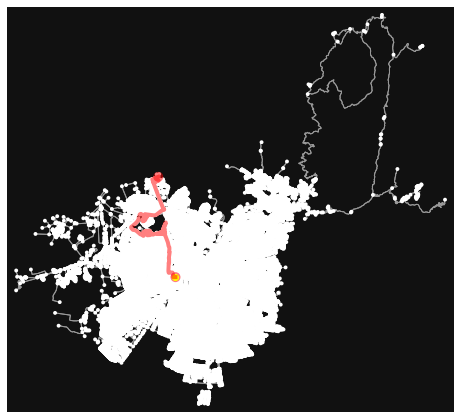

In [232]:
#predecessors = {1882519126: 1882519127, 1882519128: 1882519126, 990525992: 1882519128, 280839665: 990525992, 280841556: 280839665, 4431541904: 280841556, 280841163: 4431541904, 4431541896: 280841163, 280839907: 4431541896, 4431607727: 280839907, 4431607728: 4431607727, 4431607729: 4431607728, 280840782: 4431607729, 4431666678: 280840782, 4431666679: 4431666678, 4431666680: 4431666679, 280840815: 4431666680, 280840963: 280840815, 280840857: 280840963, 458570448: 280840857, 458570596: 458570448, 280841168: 458570596, 280841167: 280841168, 4431541898: 280841167, 280840205: 4431541898, 280840223: 280840205, 4431541897: 280840223, 280841164: 4431541897, 4431541905: 280841164, 8578447784: 4431541905, 8578447782: 8578447784, 8578447783: 8578447782, 458570637: 8578447783, 1795173214: 458570637, 8625017716: 1795173214, 1795173211: 8625017716, 5569835086: 1795173211, 4431703608: 5569835086, 280838628: 4431703608, 6548809030: 280838628, 280838626: 6548809030, 6055947268: 280838626, 5569845347: 6055947268, 5569835064: 5569845347, 3407196693: 5569835064, 3407196716: 3407196693, 2612785652: 3407196716, 4431703609: 2612785652, 592637501: 4431703609, 412208254: 592637501, 411229743: 412208254, 1989046190: 411229743, 411229746: 1989046190, 6546391161: 411229746, 3998083253: 6546391161, 411229747: 3998083253, 463042142: 411229747, 1842837626: 463042142, 4441349556: 1842837626, 605146258: 4441349556, 605146672: 605146258, 593681766: 605146672, 593723145: 593681766, 593723121: 593723145, 990511654: 593723121, 990511637: 990511654, 274495850: 990511637, 274496059: 274495850, 605146280: 274496059, 471275009: 605146280, 471275020: 471275009, 471275010: 471275020, 3878900659: 471275010, 2086694353: 3878900659, 307348811: 2086694353, 4453878865: 307348811, 264246387: 4453878865, 3733178225: 264246387, 370203605: 3733178225, 4422690365: 370203605, 6285254903: 4422690365, 264245833: 6285254903, 264246091: 264245833, 264246579: 264246091, 264245049: 264246579, 254346928: 264245049, 254346790: 254346928, 254343802: 254346790, 254343801: 254343802, 503445379: 254343801, 254346497: 503445379, 253281889: 254346497, 253281888: 253281889, 253281855: 253281888, 253281856: 253281855, 253281837: 253281856, 253281836: 253281837, 253281835: 253281836, 253411484: 253281835, 253282030: 253411484, 253281843: 253282030, 253282028: 253281843, 14095459: 253282028, 264248420: 14095459, 2212136922: 264248420, 253281999: 2212136922, 1873262215: 253281999, 254347313: 1873262215, 1584209737: 254347313, 253282327: 1584209737, 253282326: 253282327, 253282328: 253282326, 265690257: 253282328, 265690337: 265690257, 376263941: 265690337, 376263958: 376263941, 265690374: 376263958, 465140905: 265690374, 465140904: 465140905, 376264329: 465140904, 253282284: 376264329, 253282300: 253282284, 253282315: 253282300, 615098334: 253282315, 501544606: 615098334, 2389935311: 501544606, 6170121509: 2389935311, 6170121510: 6170121509, 265689527: 6170121510, 265689526: 265689527, 265689525: 265689526, 265689551: 265689525, 265689564: 265689551, 265689523: 265689564, 265689530: 265689523, 265689563: 265689530, 265689550: 265689563, 265689532: 265689550, 265689536: 265689532, 265689533: 265689536, 265689890: 265689533, 265689534: 265689890, 265689528: 265689534, 265689904: 265689528, 13882202: 265689904, 150930592: 13882202, 15092707: 150930592, 501544533: 15092707, 615098332: 501544533, 494719097: 615098332, 265690372: 494719097, 663097157: 265690372, 663097164: 663097157, 265690396: 663097164, 663097163: 265690396, 663097165: 663097163, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282330: 253282322, 254347646: 253282330, 254347743: 254347646, 254347535: 254347743, 254347531: 254347535, 376283258: 254347531, 376283252: 376283258, 376283251: 376283252, 254347532: 376283251, 376283247: 254347532, 376283184: 376283247, 376282771: 376283184, 254347529: 376282771, 254347511: 254347529, 376282803: 254347511, 254347513: 376282803, 254347515: 254347513, 5780238387: 254347515, 663097155: 5780238387, 621912516: 663097155, 254347647: 621912516, 254347479: 254347647, 253282124: 254347479, 253282324: 253282124, 253282325: 253282324, 253282125: 253282325, 376280359: 253282125, 254347480: 376280359, 990658098: 254347480, 376268993: 990658098, 990658101: 376268993, 990658090: 990658101, 289348780: 990658090, 990658094: 289348780, 990658095: 990658094, 14528348: 990658095, 14528345: 14528348, 265506674: 14528345, 376271391: 265506674, 990658071: 376271391, 3878961593: 990658071, 990658081: 3878961593, 990658083: 990658081, 265983490: 990658083, 990658055: 265983490, 265983305: 990658055, 265984184: 265983305, 265984182: 265984184, 265984181: 265984182, 265984180: 265984181, 265984209: 265984180, 265984326: 265984209, 149899259: 265984326, 4394237410: 149899259, 265690428: 4394237410, 265690434: 265690428, 265690435: 265690434, 265690441: 265690435, 265690443: 265690441, 376265780: 265690443, 376265781: 376265780, 990658074: 376265781, 376265784: 990658074, 5780308194: 376265784, 513707166: 5780308194, 494719143: 513707166, 494719144: 494719143, 376267665: 494719144, 376286448: 376267665, 265690864: 376286448, 265690885: 265690864, 376267692: 265690885, 265690902: 376267692, 265981721: 265690902, 265981783: 265981721, 265980908: 265981783, 2352416452: 265980908, 265981793: 2352416452, 265981794: 265981793, 265981675: 265981794, 265981784: 265981675, 265981722: 265981784, 265981723: 265981722, 265690490: 265981723, 265690904: 265690490, 265690903: 265690904, 265690883: 265690903, 265690889: 265690883, 265690886: 265690889, 265690887: 265690886, 265690896: 265690887, 265690865: 265690896, 265690846: 265690865, 3481551032: 265690846, 494719116: 3481551032, 605143649: 494719116, 2911534488: 605143649, 2909706699: 2911534488, 265690852: 2909706699, 3481551020: 265690852, 7940185031: 3481551020, 471724547: 7940185031, 3481551040: 471724547, 3481551037: 3481551040, 3481551046: 3481551037, 265690611: 3481551046, 265690599: 265690611, 2909701575: 265690599, 265690553: 2909701575, 265690574: 265690553, 605143639: 265690574, 265690596: 605143639, 265690612: 265690596, 265690614: 265690612, 4424066550: 265690614, 265978420: 4424066550, 265978477: 265978420, 254841997: 265978477, 254842029: 254841997, 254842874: 254842029, 265978478: 254842874, 1390406804: 265978478, 1390406807: 1390406804, 254842642: 1390406807, 254841791: 254842642, 254842872: 254841791, 265978775: 254842872, 265978774: 265978775, 265978806: 265978774, 376269841: 265978806, 265978776: 376269841, 267803066: 265978776, 376269797: 267803066, 265990152: 376269797, 289353949: 265990152, 289353922: 289353949, 5008369956: 289353922, 254841673: 5008369956, 376278116: 254841673, 254347202: 376278116, 254347240: 254347202, 4401924803: 254347240, 4401924813: 4401924803, 663097797: 4401924813, 1570459916: 663097797, 253282127: 1570459916, 376280952: 253282127, 376280777: 376280952, 376280358: 376280777, 376280668: 376280358, 376280781: 376280668, 376280884: 376280781, 254347483: 376280884, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 990614019: 990614015, 990614003: 990614019, 990614010: 990614003, 289348749: 990614010, 289352811: 289348749, 289353531: 289352811, 267803145: 289353531, 990613994: 267803145, 621918461: 990613994, 267803109: 621918461, 267802975: 267803109, 267803065: 267802975, 267802973: 267803065, 5755162789: 267802973, 267802974: 5755162789, 254842716: 267802974, 267803135: 254842716, 254842385: 267803135, 265978803: 254842385, 265978710: 265978803, 254842386: 265978710, 254842387: 254842386, 2909665191: 254842387, 254842388: 2909665191, 254842389: 254842388, 265978540: 254842389, 265978541: 265978540, 265690660: 265978541, 2909701543: 265690660, 265690667: 2909701543, 265690671: 265690667, 265690669: 265690671, 3481524425: 265690669, 5716230532: 3481524425, 14528457: 5716230532, 3481551026: 14528457, 3481459241: 3481551026, 265690847: 3481459241, 265690867: 265690847, 376286916: 265690867, 376287018: 376286916, 265690866: 376287018, 376287400: 265690866, 376287353: 376287400, 376287458: 376287353, 376287514: 376287458, 5780308192: 376287514, 253282288: 5780308192, 376287545: 253282288, 6219109399: 376287545, 6456689345: 6219109399, 6456689346: 6456689345, 376287469: 6456689346, 376287427: 376287469, 265690895: 376287427, 376287016: 265690895, 376286947: 376287016, 376286671: 376286947, 376287055: 376286671, 265690893: 376287055, 253282289: 265690893, 265690901: 253282289, 376285741: 265690901, 265981182: 376285741, 265981179: 265981182, 265981183: 265981179, 265690848: 265981183, 265981773: 265690848, 265981480: 265981773, 265981744: 265981480, 265981785: 265981744, 265981771: 265981785, 265981729: 265981771, 5779796622: 265981729, 265981478: 5779796622, 265980907: 265981478, 265981489: 265980907, 265981676: 265981489, 265981490: 265981676, 265980408: 265981490, 265981678: 265980408, 265980867: 265981678, 265980808: 265980867, 265984296: 265980808, 265984005: 265984296, 265983897: 265984005, 265980708: 265983897, 1980573543: 265980708, 265980705: 1980573543, 265980696: 265980705, 265980697: 265980696, 265980864: 265980697, 265980866: 265980864, 265981488: 265980866, 265981549: 265981488, 265981861: 265981549, 265980906: 265981861, 265980911: 265980906, 265981727: 265980911, 265981177: 265981727, 265981181: 265981177, 376285838: 265981181, 376285775: 376285838, 265981180: 376285775, 265981175: 265981180, 5727178257: 265981175, 6456689348: 5727178257, 605143615: 6456689348, 1040338400: 605143615, 265981573: 1040338400, 265981585: 265981573, 376285600: 265981585, 376285498: 376285600, 265981583: 376285498, 265981547: 265981583, 376285579: 265981547, 376285683: 376285579, 376285627: 376285683, 376285516: 376285627, 265981486: 376285516, 265980405: 265981486, 265980413: 265980405, 265980646: 265980413, 265980702: 265980646, 265980700: 265980702, 265980643: 265980700, 265690805: 265980643, 265980503: 265690805, 265980504: 265980503, 265980500: 265980504, 265980491: 265980500, 4397962591: 265980491, 265980410: 4397962591, 265980475: 265980410, 265980485: 265980475, 265980484: 265980485, 265980490: 265980484, 265980499: 265980490, 265980515: 265980499, 265980514: 265980515, 265980513: 265980514, 265690526: 265980513, 265983717: 265690526, 265983648: 265983717, 265983914: 265983648, 265983913: 265983914, 265983912: 265983913, 265983911: 265983912, 265984004: 265983911, 265984068: 265984004, 265983899: 265984068, 265983772: 265983899, 265983764: 265983772, 265983304: 265983764, 265983771: 265983304, 265983901: 265983771, 265983902: 265983901, 2914709766: 265983902, 605142915: 2914709766, 4394237428: 605142915, 3878961569: 4394237428, 473605180: 3878961569, 2737220982: 473605180, 376265232: 2737220982, 254347808: 376265232, 265690433: 254347808, 254347809: 265690433, 149899243: 254347809, 149899232: 149899243, 5732569492: 149899232, 4401722666: 5732569492, 4401722673: 4401722666, 149899140: 4401722673, 149899221: 149899140, 265690053: 149899221, 609297568: 265690053, 609297608: 609297568, 609297685: 609297608, 265689777: 609297685, 265689794: 265689777, 265689813: 265689794, 5706417281: 265689813, 265689562: 5706417281, 609297731: 265689562, 265689834: 609297731, 6307272096: 265689834, 265689888: 6307272096, 265689836: 265689888, 265689837: 265689836, 265689535: 265689837, 252819340: 265689535, 663085323: 252819340, 4455753371: 663085323, 3921015598: 4455753371, 2219964952: 3921015598, 6061170868: 2219964952, 250932052: 6061170868, 250932065: 250932052, 250932066: 250932065, 6047353958: 250932066, 250932068: 6047353958, 250931998: 250932068, 4401924823: 250931998, 250932324: 4401924823, 250932323: 250932324, 250932197: 250932323, 5362607476: 250932197, 250932321: 5362607476, 250931999: 250932321, 250932000: 250931999, 250932124: 250932000, 4469072066: 250932124, 250932142: 4469072066, 250932143: 250932142, 250932260: 250932143, 250932404: 250932260, 250932195: 250932404, 609297818: 250932195, 250932001: 609297818, 250931980: 250932001, 15379894: 250931980, 250932194: 15379894, 250932176: 250932194, 250932261: 250932176, 4401471316: 250932261, 609286380: 4401471316, 141061715: 609286380, 14528421: 141061715, 609286291: 14528421, 4470007483: 609286291, 609286378: 4470007483, 14528418: 609286378, 141061587: 14528418, 141061302: 141061587, 370168926: 141061302, 15092710: 370168926, 4455574694: 15092710, 4455574695: 4455574694, 14528425: 4455574695, 14528429: 14528425, 1900607656: 14528429, 5683084794: 1900607656, 6044687499: 5683084794, 3903499669: 6044687499, 5065323708: 3903499669, 3891166960: 5065323708, 4470028394: 3891166960, 3891166156: 4470028394, 3891166153: 3891166156, 3891166152: 3891166153, 1060423282: 3891166152, 265688323: 1060423282, 271981705: 265688323, 141061506: 271981705, 4401442555: 141061506, 141061460: 4401442555, 141061686: 141061460, 141061476: 141061686, 264248450: 141061476, 4470028390: 264248450, 1857514346: 4470028390, 13885196: 1857514346, 609286195: 13885196, 6044687500: 609286195, 141061381: 6044687500, 3301484072: 141061381, 3301484071: 3301484072, 3331853471: 3301484071, 13882310: 3331853471, 609293230: 13882310, 609293226: 609293230, 609293218: 609293226, 609293220: 609293218, 609293227: 609293220, 609293228: 609293227, 3409729158: 609293228, 5357794637: 3409729158, 6231484046: 5357794637, 609289233: 6231484046, 7671726653: 609289233, 13882309: 7671726653, 15092719: 13882309, 609286216: 15092719, 609286180: 609286216, 141061274: 609286180, 609286600: 141061274, 609286193: 609286600, 16107322: 609286193, 141061128: 16107322, 4434928984: 141061128, 4399529555: 4434928984, 605143971: 4399529555, 141061673: 605143971, 4765531800: 141061673, 14083350: 4765531800, 4401442531: 14083350, 253411478: 4401442531, 253411475: 253411478, 5268807077: 253411475, 6809871672: 5268807077, 253411557: 6809871672, 1060423266: 253411557, 612756370: 1060423266, 253411532: 612756370, 253282016: 253411532, 265688241: 253282016, 253281923: 265688241, 253411520: 253281923, 253411522: 253411520, 5419066246: 253411522, 253411525: 5419066246, 605145672: 253411525, 605145694: 605145672, 4401437046: 605145694, 4455192256: 4401437046, 254344723: 4455192256, 253411563: 254344723, 253411565: 253411563, 265688240: 253411565, 253411560: 265688240, 253411549: 253411560, 4448461357: 253411549, 4448461358: 4448461357, 253282032: 4448461358, 605144029: 253282032, 253282017: 605144029, 265688239: 253282017, 253282023: 265688239, 253411536: 253282023, 253411539: 253411536, 4455192257: 253411539, 4401437045: 4455192257, 253411470: 4401437045, 253411468: 253411470, 253281885: 253411468, 253411463: 253281885, 265688238: 253411463, 253282018: 265688238, 276078286: 253282018, 253282019: 276078286, 253282020: 253282019, 265688236: 253282020, 253281766: 265688236, 14760683: 253281766, 605145695: 14760683, 227926109: 605145695, 265688244: 227926109, 254344725: 265688244, 5917404325: 254344725, 369945287: 5917404325, 254346506: 369945287, 254346503: 254346506, 6014064393: 254346503, 605145696: 6014064393, 6812100771: 605145696, 5220596193: 6812100771, 254346560: 5220596193, 254346663: 254346560, 605145699: 254346663, 605145683: 605145699, 3458654252: 605145683, 253281817: 3458654252, 605145693: 253281817, 254346672: 605145693, 254346676: 254346672, 254346563: 254346676, 254346688: 254346563, 254346565: 254346688, 254346671: 254346565, 2041792921: 254346671, 254343740: 2041792921, 7671897194: 254343740, 254346870: 7671897194, 254346669: 254346870, 254346567: 254346669, 254346808: 254346567, 254346700: 254346808, 264247293: 254346700, 227925875: 264247293, 6701687242: 227925875, 605183922: 6701687242, 307081718: 605183922, 227925719: 307081718, 369945456: 227925719, 227925743: 369945456, 227925756: 227925743, 227925773: 227925756, 253281801: 227925773, 2970880237: 253281801, 3046679881: 2970880237, 2792557264: 3046679881, 253281792: 2792557264, 3577082421: 253281792, 4448453628: 3577082421, 253281790: 4448453628, 253281771: 253281790, 253281774: 253281771, 4452607424: 253281774, 265688234: 4452607424, 265688233: 265688234, 141061147: 265688233, 13877040: 141061147, 141061596: 13877040, 13877045: 141061596, 13877044: 13877045, 141061251: 13877044, 141061325: 141061251, 13877038: 141061325, 1223293566: 13877038, 6456689365: 1223293566, 1223293812: 6456689365, 5357935895: 1223293812, 5300250129: 5357935895, 476178061: 5300250129, 5916965028: 476178061, 369965187: 5916965028, 369961560: 369965187, 369965719: 369961560, 1597018428: 369965719, 1597018435: 1597018428, 3888644717: 1597018435, 4456599097: 3888644717, 5419366819: 4456599097, 253366596: 5419366819, 2025475946: 253366596, 609293242: 2025475946, 3887077722: 609293242, 2025475957: 3887077722, 369965811: 2025475957, 4130454005: 369965811, 609293245: 4130454005, 150924803: 609293245, 265689367: 150924803, 265689434: 265689367, 265689432: 265689434, 265689365: 265689432, 6405681798: 265689365, 149888132: 6405681798, 6061312661: 149888132, 6055341086: 6061312661, 1196458236: 6055341086, 2212136899: 1196458236, 265689781: 2212136899, 265689780: 265689781, 5721132020: 265689780, 5721132019: 5721132020, 5721132013: 5721132019, 5721132027: 5721132013, 265689779: 5721132027, 609297665: 265689779, 149899175: 609297665, 370171302: 149899175, 149899191: 370171302, 265689560: 149899191, 265689580: 265689560, 265689624: 265689580, 265689578: 265689624, 265690055: 265689578, 265689706: 265690055, 265689708: 265689706, 370171128: 265689708, 370171074: 370171128, 265689581: 370171074, 370171483: 265689581, 370171286: 370171483, 370171601: 370171286, 265689582: 370171601, 6314487795: 265689582, 150930591: 6314487795, 265689583: 150930591, 5706483194: 265689583, 5706483199: 5706483194, 150923725: 5706483199, 265689716: 150923725, 575459089: 265689716, 265689714: 575459089, 609297586: 265689714, 609297581: 609297586, 265689712: 609297581, 370202903: 265689712, 370202902: 370202903, 370202901: 370202902, 370202918: 370202901, 265689675: 370202918, 265689674: 265689675, 265689673: 265689674, 265689672: 265689673, 265689690: 265689672, 265689679: 265689690, 5917118236: 265689679, 615098302: 5917118236, 149899276: 615098302, 1899251391: 149899276, 1899251398: 1899251391, 1899251400: 1899251398, 1899251366: 1899251400, 627959265: 1899251366, 8015660146: 627959265, 8015660145: 8015660146, 1899255342: 8015660145, 627942912: 1899255342, 5796906760: 627942912, 276857631: 5796906760, 276857633: 276857631, 473605689: 276857633, 276858716: 473605689, 276858752: 276858716, 436325087: 276858752, 436325202: 436325087, 4394237436: 436325202, 605142905: 4394237436, 605142909: 605142905, 265983645: 605142909, 265983646: 265983645, 265983715: 265983646, 265983303: 265983715, 265983268: 265983303, 605142894: 265983268, 605142893: 605142894, 4394237438: 605142893, 276858731: 4394237438, 436325124: 276858731, 436325398: 436325124, 436325205: 436325398, 4394237440: 436325205, 276858710: 4394237440, 436325151: 276858710, 436325157: 436325151, 436325263: 436325157, 436325267: 436325263, 436325270: 436325267, 276858690: 436325270, 276858691: 276858690, 605142892: 276858691, 605142898: 605142892, 4394237439: 605142898, 265983302: 4394237439, 265983336: 265983302, 265980552: 265983336, 265980516: 265980552, 265980517: 265980516, 265980518: 265980517, 265980474: 265980518, 265980401: 265980474, 265980427: 265980401, 265980363: 265980427, 265980362: 265980363, 265690764: 265980362, 265690727: 265690764, 265690771: 265690727, 265980361: 265690771, 376288227: 265980361, 376288230: 376288227, 376288232: 376288230, 376288431: 376288232, 265690741: 376288431, 265690749: 265690741, 265987141: 265690749, 265987148: 265987141, 265987139: 265987148, 376289192: 265987139, 376289173: 376289192, 2903328862: 376289173, 265690723: 2903328862, 282085580: 265690723, 376289193: 282085580, 282085613: 376289193, 282085436: 282085613, 265690724: 282085436, 265690747: 265690724, 265690775: 265690747, 265690774: 265690775, 265690773: 265690774, 265690772: 265690773, 265690788: 265690772, 265690787: 265690788, 265690726: 265690787, 265690725: 265690726, 265690743: 265690725, 265690767: 265690743, 265690766: 265690767, 265690765: 265690766, 265690786: 265690765, 265690785: 265690786, 265690751: 265690785, 265690687: 265690751, 265690745: 265690687, 265690746: 265690745, 265690768: 265690746, 265690721: 265690768, 265690722: 265690721, 282085434: 265690722, 282085609: 282085434, 282085744: 282085609, 265690750: 282085744, 282085816: 265690750, 282085787: 282085816, 282085775: 282085787, 282093559: 282085775, 2024798547: 282093559, 282093345: 2024798547, 3481459242: 282093345, 3481499529: 3481459242, 282093410: 3481499529, 3481499536: 282093410, 3481499495: 3481499536, 265980092: 3481499495, 605143247: 265980092, 265980103: 605143247, 605143265: 265980103, 2024781663: 605143265, 4401272080: 2024781663, 2024781700: 4401272080, 2042620137: 2024781700, 2909808157: 2042620137, 2909808161: 2909808157, 2909803921: 2909808161, 2909798908: 2909803921, 2048772828: 2909798908, 5716230539: 2048772828, 2973117671: 5716230539, 2048772829: 2973117671, 4767959337: 2048772829, 2909705223: 4767959337, 2909705205: 2909705223, 2909705201: 2909705205, 265980015: 2909705201, 2042626782: 265980015, 2042626787: 2042626782, 1956795720: 2042626787, 265690674: 1956795720, 1388081232: 265690674, 1388081235: 1388081232, 772061742: 1388081235, 772062066: 772061742, 772061757: 772062066, 376273214: 772061757, 265987895: 376273214, 265978592: 265987895, 265987870: 265978592, 265979047: 265987870, 265979048: 265979047, 254842432: 265979048, 265979352: 254842432, 254842434: 265979352, 265978935: 254842434, 2909675159: 265978935, 254842333: 2909675159, 254842332: 254842333, 254842331: 254842332, 265978807: 254842331, 265979379: 265978807, 265979347: 265979379, 254842136: 265979347, 265979380: 254842136, 605143696: 265979380, 265979381: 605143696, 265979383: 265979381, 265979384: 265979383, 265979350: 265979384, 265979349: 265979350, 265979348: 265979349, 265978675: 265979348, 265978674: 265978675, 265978933: 265978674, 265979049: 265978933, 4399735755: 265979049, 4399735754: 4399735755, 265979050: 4399735754, 254842239: 265979050, 265979548: 254842239, 265979550: 265979548, 265979543: 265979550, 265979545: 265979543, 265978932: 265979545, 1841384083: 265978932, 265979142: 1841384083, 265979143: 265979142, 265978994: 265979143, 265978995: 265978994, 265978611: 265978995, 265987821: 265978611, 265987819: 265987821, 6405736127: 265987819, 2352282049: 6405736127, 376273617: 2352282049, 265987798: 376273617, 150930547: 265987798, 253295679: 150930547, 2986336937: 253295679, 2986337133: 2986336937, 1841384018: 2986337133, 1841384051: 1841384018, 1841384079: 1841384051, 1841384166: 1841384079, 265978963: 1841384166, 605143684: 265978963, 5920776354: 605143684, 605143679: 5920776354, 2986336738: 605143679, 2986336740: 2986336738, 265999698: 2986336740, 265988452: 265999698, 265988441: 265988452, 471262565: 265988441, 503519500: 471262565, 471262542: 503519500, 503519502: 471262542, 150930546: 503519502, 1809528556: 150930546, 2042555935: 1809528556, 4425394193: 2042555935, 4425394195: 4425394193, 2042555920: 4425394195, 1956795725: 2042555920, 1956795756: 1956795725, 2909251262: 1956795756, 2909251261: 2909251262, 3234763941: 2909251261, 2909251072: 3234763941, 4401300412: 2909251072, 265979816: 4401300412, 2908320703: 265979816, 265979877: 2908320703, 2024781652: 265979877, 4401272074: 2024781652, 2024781612: 4401272074, 2903371690: 2024781612, 2024781697: 2903371690, 2024781644: 2024781697, 265980042: 2024781644, 605143268: 265980042, 2024781614: 605143268, 605143260: 2024781614, 605143261: 605143260, 2024781638: 605143261, 2903336465: 2024781638, 2903331542: 2903336465, 605143241: 2903331542, 605143250: 605143241, 2024781676: 605143250, 2024781701: 2024781676, 3481499541: 2024781701, 14528464: 3481499541, 265980101: 14528464, 2024781628: 265980101, 265980046: 2024781628, 265980045: 265980046, 2024781668: 265980045, 2024781665: 2024781668, 2903359373: 2024781665, 2024781623: 2903359373, 2903361253: 2024781623, 2903362069: 2903361253, 2024781674: 2903362069, 7400295896: 2024781674, 2024781670: 7400295896, 2042555930: 2024781670, 2024781648: 2042555930, 2042574513: 2024781648, 2042555922: 2042574513, 2042555917: 2042555922, 1956795778: 2042555917, 2044172155: 1956795778, 2042535899: 2044172155, 627940183: 2042535899, 627940195: 627940183, 269846617: 627940195, 5721451729: 269846617, 512622816: 5721451729, 512622817: 512622816, 512622818: 512622817, 512622820: 512622818, 512622821: 512622820, 512622822: 512622821, 512622823: 512622822, 512622825: 512622823, 503519507: 512622825, 150926600: 503519507, 3481499503: 150926600, 3481499561: 3481499503, 605142846: 3481499561, 3481499497: 605142846, 3481499089: 3481499497, 3481499066: 3481499089, 3481499063: 3481499066, 3481499498: 3481499063, 3481499527: 3481499498, 3481499501: 3481499527, 3481499069: 3481499501, 3481499521: 3481499069, 605142852: 3481499521, 605142820: 605142852, 605142829: 605142820, 3481499091: 605142829, 3481499508: 3481499091, 3481499092: 3481499508, 605142836: 3481499092, 605142816: 605142836, 3481499502: 605142816, 376294571: 3481499502, 2024798551: 376294571, 282093561: 2024798551, 282085735: 282093561, 4399907740: 282085735, 282085703: 4399907740, 282085705: 282085703, 265690798: 282085705, 2024798554: 265690798, 2024798550: 2024798554, 2024798549: 2024798550, 2024798555: 2024798549, 265690799: 2024798555, 265690800: 265690799, 265690801: 265690800, 265690781: 265690801, 265980350: 265690781, 265980521: 265980350, 265980520: 265980521, 265980519: 265980520, 265980550: 265980519, 265980551: 265980550, 265982595: 265980551, 265983301: 265982595, 265983266: 265983301, 265983267: 265983266, 265982095: 265983267, 605142897: 265982095, 2051400948: 605142897, 436325207: 2051400948, 436325367: 436325207, 436325369: 436325367, 436325372: 436325369, 436325176: 436325372, 276858698: 436325176, 2051400950: 276858698, 436325210: 2051400950, 436325214: 436325210, 436325325: 436325214, 436325339: 436325325, 436325347: 436325339, 436325180: 436325347, 276858705: 436325180, 4473373006: 276858705, 605142711: 4473373006, 2051400949: 605142711, 605142706: 2051400949, 436325298: 605142706, 276858692: 436325298, 265984513: 276858692, 265983265: 265984513, 1980604585: 265983265, 1980604584: 1980604585, 265984515: 1980604584, 4398007270: 265984515, 282086321: 4398007270, 282086219: 282086321, 265980357: 282086219, 2911283548: 265980357, 2911283547: 2911283548, 282086100: 2911283547, 265690678: 282086100, 265980351: 265690678, 4473143548: 265980351, 4473143549: 4473143548, 2911185743: 4473143549, 282085949: 2911185743, 2911185741: 282085949, 282085918: 2911185741, 282085893: 282085918, 265980382: 282085893, 265980385: 265980382, 2903281894: 265980385, 3755605393: 2903281894, 2903277935: 3755605393, 2903277934: 2903277935, 3755605365: 2903277934, 282093605: 3755605365, 2024798545: 282093605, 265980342: 2024798545, 512622833: 265980342, 512622834: 512622833, 512622836: 512622834, 2903291827: 512622836, 2903291744: 2903291827, 282091713: 2903291744, 282091728: 282091713, 2903291745: 282091728, 2903291828: 2903291745, 512622837: 2903291828, 512622838: 512622837, 3733523325: 512622838, 282091126: 3733523325, 2914687811: 282091126, 2049701730: 2914687811, 2049701729: 2049701730, 2049701731: 2049701729, 282091714: 2049701731, 2903295248: 282091714, 605142737: 2903295248, 282091416: 605142737, 5721451318: 282091416, 2049746038: 5721451318, 2049701739: 2049746038, 2049701737: 2049701739, 5721451317: 2049701737, 2049701734: 5721451317, 2049701727: 2049701734, 282091652: 2049701727, 2049701738: 282091652, 2914687812: 2049701738, 282091125: 2914687812, 2914687750: 282091125, 512622839: 2914687750, 265984472: 512622839, 3748575034: 265984472, 282087097: 3748575034, 282087228: 282087097, 282087229: 282087228, 282086221: 282087229, 265980377: 282086221, 282085913: 265980377, 282085938: 282085913, 282086544: 282085938, 282086090: 282086544, 282086545: 282086090, 265980356: 282086545, 282086201: 265980356, 282086461: 282086201, 282086462: 282086461, 282086471: 282086462, 282086464: 282086471, 282086441: 282086464, 282086372: 282086441, 265984470: 282086372, 4398007263: 265984470, 5714430393: 4398007263, 265984469: 5714430393, 265980368: 265984469, 2973132053: 265980368, 605142768: 2973132053, 605142767: 605142768, 265690692: 605142767, 282090859: 265690692, 282090861: 282090859, 282091353: 282090861, 282090914: 282091353, 1980618080: 282090914, 1980618077: 1980618080, 265980383: 1980618077, 282087225: 265980383, 1980618079: 282087225, 1980619106: 1980618079, 282090925: 1980619106, 918111158: 282090925, 918111109: 918111158, 282090940: 918111109, 282090943: 282090940, 282091561: 282090943, 282091670: 282091561, 282091556: 282091670, 282091557: 282091556, 1856659210: 282091557, 282091052: 1856659210, 1980618120: 282091052, 282091508: 1980618120, 282091532: 282091508, 5714508000: 282091532, 282091418: 5714508000, 282091617: 282091418, 282091417: 282091617, 2049701732: 282091417, 2049701736: 2049701732, 2049701735: 2049701736, 2049701733: 2049701735, 605142716: 2049701733, 282087366: 605142716, 1980622903: 282087366, 2049701728: 1980622903, 282091420: 2049701728, 288989748: 282091420, 855668850: 288989748, 288989701: 855668850, 2049722050: 288989701, 1857514372: 2049722050, 5719116930: 1857514372, 2049722052: 5719116930, 2049743542: 2049722052, 288989702: 2049743542, 282092276: 288989702, 3748574724: 282092276, 3748574723: 3748574724, 2215421214: 3748574723, 5719116927: 2215421214, 918111190: 5719116927, 282092858: 918111190, 3481499090: 282092858, 855668808: 3481499090, 2049728666: 855668808, 855668892: 2049728666, 2903321732: 855668892, 282093062: 2903321732, 2049728664: 282093062, 282093112: 2049728664, 3751119853: 282093112, 282093096: 3751119853, 282093068: 282093096, 282092898: 282093068, 282093033: 282092898, 5721451727: 282093033, 282092730: 5721451727, 282092820: 282092730, 282092847: 282092820, 282092495: 282092847, 2888231802: 282092495, 2888194155: 2888231802, 282092807: 2888194155, 282092791: 282092807, 282092787: 282092791, 282098348: 282092787, 282092974: 282098348, 2888211893: 282092974, 282092910: 2888211893, 282092729: 282092910, 282092789: 282092729, 288989558: 282092789, 288989556: 288989558, 282091914: 288989556, 2888223468: 282091914, 282098323: 2888223468, 282098322: 282098323, 282098347: 282098322, 282098320: 282098347, 2044172157: 282098320, 288988979: 2044172157, 288988972: 288988979, 288988960: 288988972, 288988951: 288988960, 288989225: 288988951, 288989285: 288989225, 288989340: 288989285, 288989330: 288989340, 288989359: 288989330, 288989357: 288989359, 288989356: 288989357, 288989358: 288989356, 288989350: 288989358, 288989313: 288989350, 288989314: 288989313, 513707188: 288989314, 288989329: 513707188, 288989338: 288989329, 513707186: 288989338, 288989339: 513707186, 288989333: 288989339, 288989065: 288989333, 288989064: 288989065, 288989075: 288989064, 288989291: 288989075, 288989282: 288989291, 288989284: 288989282, 288989234: 288989284, 288989228: 288989234, 288988949: 288989228, 1841392267: 288988949, 288989052: 1841392267, 288989053: 288989052, 1841392253: 288989053, 1841392273: 1841392253, 288988957: 1841392273, 288989054: 288988957, 288988953: 288989054, 288989226: 288988953, 288989224: 288989226, 288988961: 288989224, 513707180: 288988961, 288988958: 513707180, 288988991: 288988958, 288988986: 288988991, 513707178: 288988986, 288988982: 513707178, 288989223: 288988982, 288988978: 288989223, 288988971: 288988978, 288988988: 288988971, 288989096: 288988988, 605139718: 288989096, 4403544939: 605139718, 4403544937: 4403544939, 288988970: 4403544937, 288988952: 288988970, 269846478: 288988952, 269846483: 269846478, 2888192096: 269846483, 2888195222: 2888192096, 2888195850: 2888195222, 2888195956: 2888195850, 2888187723: 2888195956, 605141807: 2888187723, 288989087: 605141807, 2888168608: 288989087, 2888185495: 2888168608, 2888185493: 2888185495, 1841392274: 2888185493, 4403544738: 1841392274, 479696182: 4403544738, 1221423942: 479696182, 1221420416: 1221423942, 718299047: 1221420416, 718299048: 718299047, 1857514349: 718299048, 4632344010: 1857514349, 1367969308: 4632344010, 1369099884: 1367969308, 1369099853: 1369099884, 265988643: 1369099853, 605143536: 265988643, 605143541: 605143536, 1841384009: 605143541, 1841384105: 1841384009, 265999693: 1841384105, 265999692: 265999693, 605143669: 265999692, 265988670: 605143669, 1841384036: 265988670, 265988680: 1841384036, 265988645: 265988680, 265988646: 265988645, 265999695: 265988646, 265999638: 265999695, 265988623: 265999638, 605142168: 265988623, 1841384191: 605142168, 265988678: 1841384191, 605142149: 265988678, 265988621: 605142149, 605142138: 265988621, 4632344011: 605142138, 4632344013: 4632344011, 265988755: 4632344013, 1841384069: 265988755, 1841384071: 1841384069, 605142177: 1841384071, 265988631: 605142177, 605142169: 265988631, 1841384143: 605142169, 265988220: 1841384143, 265988296: 265988220, 265988219: 265988296, 1841384114: 265988219, 265988093: 1841384114, 605142097: 265988093, 605141983: 605142097, 1841384117: 605141983, 265999707: 1841384117, 1841384046: 265999707, 253282562: 1841384046, 1841384031: 253282562, 1841384126: 1841384031, 1841384181: 1841384126, 1841384212: 1841384181, 1841384179: 1841384212, 1841384139: 1841384179, 265988146: 1841384139, 265988094: 265988146, 1841384107: 265988094, 605142047: 1841384107, 605142046: 605142047, 605142049: 605142046, 605142048: 605142049, 265988147: 605142048, 265988298: 265988147, 265988148: 265988298, 1841384021: 265988148, 605142051: 1841384021, 1841384033: 605142051, 605142052: 1841384033, 1841384010: 605142052, 265999691: 1841384010, 1841384111: 265999691, 4764330614: 1841384111, 265988096: 4764330614, 2887730644: 265988096, 1841384001: 2887730644, 2887731178: 1841384001, 1841384208: 2887731178, 1841384088: 1841384208, 253282565: 1841384088, 1867508093: 253282565, 503519515: 1867508093, 479696166: 503519515, 479696169: 479696166, 253282527: 479696169, 471266863: 253282527, 471266867: 471266863, 265999579: 471266867, 265999582: 265999579, 265999586: 265999582, 265999589: 265999586, 265999584: 265999589, 265999580: 265999584, 265999578: 265999580, 471266871: 265999578, 288989100: 471266871, 288989107: 288989100, 288989108: 288989107, 288989111: 288989108, 288989162: 288989111, 288989118: 288989162, 2041917155: 288989118, 288989116: 2041917155, 288989114: 288989116, 288989091: 288989114, 288989117: 288989091, 812309740: 288989117, 288989160: 812309740, 4403544929: 288989160, 288989164: 4403544929, 269846482: 288989164, 2887695137: 269846482, 812309682: 2887695137, 288990113: 812309682, 288990129: 288990113, 288990126: 288990129, 288990128: 288990126, 288990061: 288990128, 605139636: 288990061, 605139641: 605139636, 605139642: 605139641, 288990104: 605139642, 282094485: 288990104, 282094654: 282094485, 269846549: 282094654, 282098307: 269846549, 282098367: 282098307, 282098324: 282098367, 376293886: 282098324, 282098262: 376293886, 2888230274: 282098262, 2888230236: 2888230274, 282091916: 2888230236, 282097503: 282091916, 282091761: 282097503, 282097839: 282091761, 282097933: 282097839, 282093811: 282097933, 282097850: 282093811, 282098556: 282097850, 605139669: 282098556, 2888242101: 605139669, 282091825: 2888242101, 282092342: 282091825, 282094332: 282092342, 282094337: 282094332, 282093908: 282094337, 282094214: 282093908, 282093911: 282094214, 282094190: 282093911, 282093809: 282094190, 282094273: 282093809, 282094270: 282094273, 282093812: 282094270, 282094380: 282093812, 2888233916: 282094380, 2888234374: 2888233916, 5719116925: 2888234374, 2048409873: 5719116925, 282097552: 2048409873, 282097498: 282097552, 282097594: 282097498, 282097558: 282097594, 282097491: 282097558, 282097505: 282097491, 282097066: 282097505, 282094846: 282097066, 282097295: 282094846, 2888242112: 282097295, 4401517853: 2888242112, 282097311: 4401517853, 282091032: 282097311, 282097229: 282091032, 282088671: 282097229, 282094847: 282088671, 282088672: 282094847, 282094853: 282088672, 282097251: 282094853, 513707201: 282097251, 2888234373: 513707201, 2888233917: 2888234373, 282094587: 2888233917, 282093824: 282094587, 282094193: 282093824, 282094652: 282094193, 5721451307: 282094652, 282094583: 5721451307, 288989755: 282094583, 288989750: 288989755, 282091642: 288989750, 288989760: 282091642, 282091419: 288989760, 282091389: 282091419, 282091457: 282091389, 282091600: 282091457, 282091599: 282091600, 871514871: 282091599, 1980618122: 871514871, 1980618121: 1980618122, 282091054: 1980618121, 282091147: 282091054, 282091123: 282091147, 282091145: 282091123, 463129676: 282091145, 1814534802: 463129676}
path = a[0]
#4038709141
#path = []
#pred = 1814534802
#while pred != None:
 #   path.append(pred)
  #  pred=predecessors.get(pred,None)
# reverses the array, to display the path nicely
#readable = path[0]
path = path[::-1]

fig, ax = ox.plot_graph_route(grafi, path, show = False, close = False)
ax.scatter(direccion_y[list_id.index(265690338)], direccion_x[list_id.index(265690338)], c='yellow')
plt.show()

# Ruta mínima entre cada par

def subgrafoX(graph, src, dest, k):
    k_rutas = ox.distance.k_shortest_paths(graph, src, dest, k, weight='Tiempos de Viaje')
    lista_sets = []
    for counter, path in enumerate(k_rutas):
        lista_sets.append(set(path))
        if counter == k-1:
             break
    nodos = list(reduce(operator.or_, lista_sets))
    subgrafo = graph.subgraph(nodos)
    return subgrafo

**Actualizamos valores de arcos en el grafo de santiago, ahora se llamará G contiene velocidad con congestión**

In [ ]:
# G  = ox.utils_graph.graph_from_gdfs(nodes , edges , graph_attrs = None)

In [ ]:
# nodesG, edgesG = ox.graph_to_gdfs(G)

**Ahora podemos calcular la ruta mínima entre dos nodos, bajo cualquier atributo de arco**

#### Función que debe ir calculando los costos que difieren del tiempo

(56.83*(edges[lenght]/1000)) ---------------> Todos los arcos

(sumar + 21378) -----------------------------> Arcos salientes del depot

In [ ]:
def costos_agregados(path):
    agregados = 0
    for n in range(len(path)-1):
        if path[len(path)-1] == 1882519127 and agregados == 0:
            agregados += 21378
        else:
            agregados += (56.83 * graph[path[n+1]][path[n]][0]['length'])/1000
    return (agregados)

##### Función que calcula la ruta mínima entre cada par de nodos

In [ ]:
# Calculate the shortest path dinamic time
def rutas_min_pares(G, list_id, mes, hora, minutos):
    caminos = []
    tiempo_inicial = time() 
    dic_rutas = {}
    #G = ox.utils_graph.graph_from_gdfs(nodes , edges , graph_attrs = None)
    visitados = set()
    subgrafos = {}
    for n1 in list_id:
        for n2 in list_id:
            if n1 != n2 and nx.has_path(G, n1,n2):
                if (n1, n2) not in visitados:
                    subg = subgrafo(G, n1, direccion_x, direccion_y, list_id.index(n1), list_id.index(n2))
                    subgrafos[(n2, n1)] = subg
                    visitados.add((n2, n1))
                else:
                    subg = subgrafos[(n2, n1)]
                
                nodes_subg, edges_subg = ox.graph_to_gdfs(subg)
                path, tiempo = vecino_cercano(grafi, nodes_subg,  n1, n2, mes, hora, minutos, 0, set(), {}, set(), {})
                print('-------------------------------------------------------------------------------------------------------------------------------------------------')
                print('Encontro ruta min con Vecino Cercano del par de nodos', (n1, n2))
                print('-------------------------------------------------------------------------------------------------------------------------------------------------')
                costo_agregado = costos_agregados(path)
                dic_rutas[(path[0], path[-1])] = [tiempo, costo_agregado]   
                caminos.append(path)
                print('***'*30)
                print('El camino entre el nodo', n1, 'y', n2, 'fue:', path)
                print('***'*30)
                
    tiempo_final = time() 
    tiempo_ejecucion = tiempo_final - tiempo_inicial
    print ('El tiempo de ejecucion en minutos fue:', tiempo_ejecucion/60)
    return(dic_rutas)

In [ ]:
# ahora se calculan las rutas mínimas entre cada par
dic_rutas = (rutas_min_pares(graph_s, list_id, 6, 9, 0))

In [ ]:
#print(dic_rutas)

Notamos que al ocupar el método 'haversine' se repite un nodo, debido a la cercania. De modo que dejaremos ese nodo con su id euclidiano.

**Revisamos todos los pares de nodos que efectivamente no tienen ruta entre sí**

In [ ]:
pares_sin_ruta = []
for n1 in list_id:
        for n2 in list_id:
            if n1 != n2 and nx.has_path(G, n1, n2)==False:
                pares_sin_ruta.append((n1, n2))
                
print('Los siguientes pares no tienen rutas entre sí:', pares_sin_ruta)

Hay 11 pares sin ruta entre sí

# -----------------------------------------------------------------------------------------------------

In [ ]:
"""# Necesitamos ahora, crear la estructura de grafo sin calles con los costos reales en los arcos entre cada par o-d
#Se importa la libreria networkx como nx

import networkx as nx

#Se importa la libreria pyplot de matplotlib como plt

import matplotlib.pyplot as plt

#Se crea un grafo asimétrico vacio

G = nx.DiGraph()

#Se crean los nodos:

#Se crean los nodos depot + clientes

G.add_nodes_from(list_id)

#Se crean los arcos entre los nodos
for a in dic_rutas:
    G.add_edge(a[0], a[1])
    G.edges[(a[0], a[1])]['Costo']= dic_rutas[a]
for n in G.nodes:
    if n == 267454352:
        G.nodes[n]['Depot'] = True
    else:
        G.nodes[n]['Depot'] = False
    
#Se dibuja el grafo

nx.draw(G, node_size = 12, font_size=1)

#Se muestra en pantalla

plt.show()"""



In [ ]:
"""G.nodes"""

In [ ]:
"""G.edges"""

In [ ]:
"""G.edges[(3485642555, 4765300244)]"""

In [ ]:
"""G.nodes[613890784]"""

# Creación de datos

In [ ]:
"""n = list_id.copy()# Clientes
camiones = [k for k in range (1,4)]
list_id.remove(267454352)
clientes = list_id
u={1: 5500, 2:5500, 3:5500}

import numpy as np
rnd=np.random
rnd.seed(0)

q={i:rnd.randint(500, 1000) for i in clientes}"""

In [ ]:
"""print(n)
print(clientes)
print(camiones)
print(u)
print(q)
print(list_id)"""

In [ ]:
"""import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.scatter(direccion_x,direccion_y,color="green")

for i in clientes:
       plt.annotate('$q_{%d}=%d$'%(i,q[i]),(direccion_x[clientes.index(i)],direccion_y[clientes.index(i)]))
    
plt.plot(direccion_x[0],direccion_y[0],color='red',marker='s')
plt.annotate('DC',(direccion_x[0],direccion_y[0]))

plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.title("Gráfico de Nodos | VRP")

plt.show()"""



In [ ]:
"dic_rutas[(3485642555, 4765300244)]"

In [ ]:
""""arcos={i for i in dic_rutas.keys()}
# esto es literal dic_rutas
#distancia={(i,j):np.hypot(direccion_x[i]-direccion_x[j],direccion_y[i]-direccion_y[j]) 
          # for i in nodos for j in nodos if i!=j}
arcos"""

In [ ]:
"""plt.figure(figsize=(12,5))
plt.scatter(direccion_x,direccion_y,color="green")

for i in clientes:
    plt.annotate('$q_{%d}$'%(i),(direccion_x[clientes.index(i)],direccion_y[clientes.index(i)]))
    
plt.plot(direccion_x[0],direccion_y[0],color='red',marker='s')
plt.annotate('DC',(direccion_x[0],direccion_y[0]))

for i, j in arcos:
    plt.plot([direccion_x[n.index(i)],direccion_x[n.index(j)]],[direccion_y[n.index(i)],direccion_y[n.index(j)]],color="blue",alpha=0.3)
    #plt.annotate('C=%d'%dic_rutas[(i,j)], ((direccion_x[n.index(i)]+direccion_x[n.index(j)])/2, (direccion_y[n.index(i)]+direccion_y[n.index(j)])/2))
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.title("Grafo completo, arcos entre todo par de nodos donde existe ruta| VRP")


plt.show()"""

Fuente: https://nbviewer.jupyter.org/github/CplexPython/Cplex-Python/blob/master/VRP/CVRP%20%7C%20Cplex%20%26%20Python%20.ipynb

# Utilizando Heurísticas para resolver VRP

In [ ]:
"""# Plot the shortest path
fig, ax = ox.plot_graph_route(G, route)"""